# Import Libraries

In [ ]:
# Imports
import re
import os
import random
import config
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import mysql.connector
import pandas_profiling
import sklearn.svm as SVC
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Random
from os import system
from time import time
from math import floor
from copy import deepcopy
from IPython.display import Image
from mysql.connector import errorcode

# Webscraping
from selenium import webdriver
from bs4 import BeautifulSoup as BS
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Math
from sklearn.svm import SVC  
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from sklearn.externals.six import StringIO
from xgboost import plot_importance, plot_tree
from sklearn import metrics, preprocessing, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import label_binarize, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

# Time Series
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

# Display Preferences
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# AAPL MEAN MONTHLY CLOSES FOR ARIMA/SARIMAX

## Import csv of Apple's daily closes and graph it 

In [ ]:
aapl = pd.read_csv('AAPL.csv')
aapl.head()

In [792]:
daily_closes = aapl[:1819].groupby(['ds'])['y'].sum()

In [882]:
daily_closes = aapl[:1819]

In [883]:
daily_closes.set_index('ds', inplace=True)

In [884]:
# Make sure to set our dates to datetime for graphing purposes using ARIMA/SARIMAX
daily_closes.index = pd.to_datetime(daily_closes.index)

In [535]:
daily_closes.head()

ds          y
0 2011-01-03  40.965591
1 2011-01-04  41.179398
2 2011-01-05  41.516247
3 2011-01-06  41.482681
4 2011-01-07  41.779762

### We are going to resample this using average monthly closes over the period of time. I chose to do it this way as it provided leniency, as well as being graphically more visually appealing.

In [537]:
monthly_closes = daily_closes.resample('m').mean()

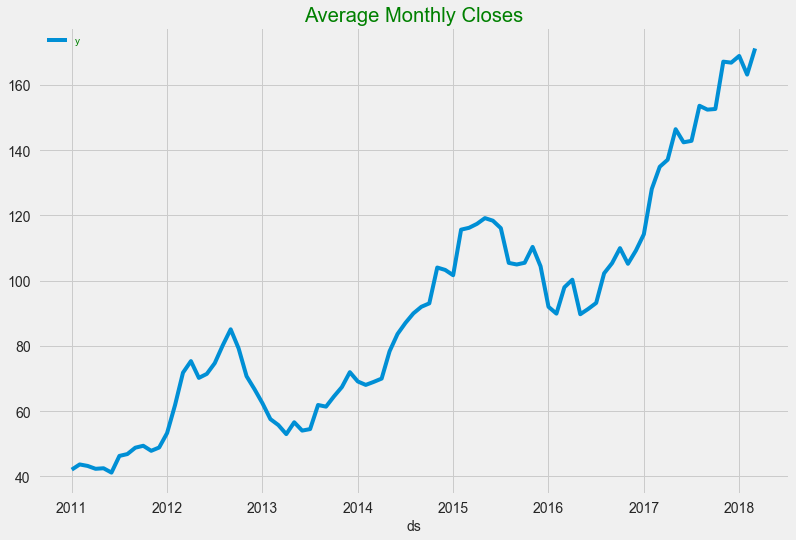

In [538]:
monthly_closes = pd.DataFrame(monthly_closes, columns=['y'])
monthly_closes.plot(figsize=(12,8), title= 'Average Monthly Closes', fontsize=14);

## Plot a seasonal decomposition

<Figure size 432x288 with 0 Axes>

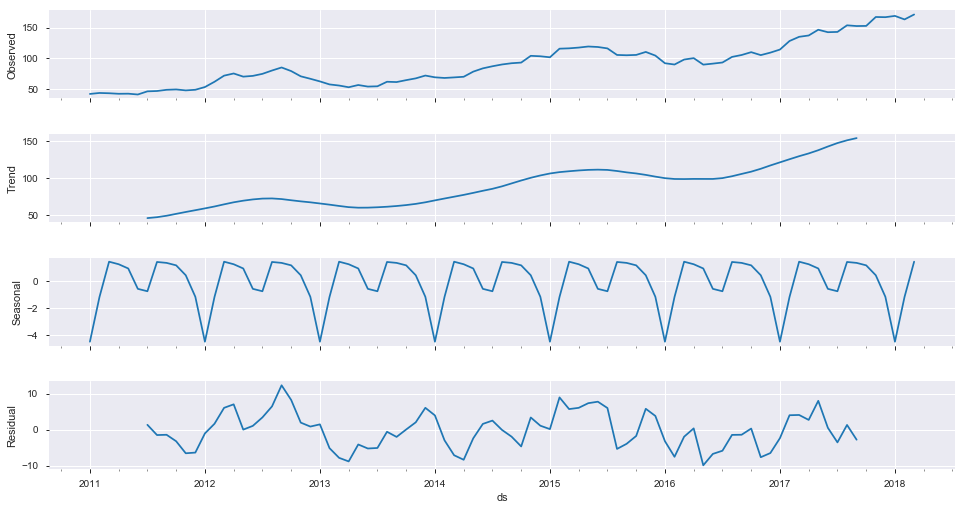

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_closes, freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8);

In [294]:
# Since we are using monthly averages, set the window to 30 
monthly_closes.rolling(window=30).mean()

ds
2011-01-03           NaN
2011-01-04           NaN
2011-01-05           NaN
2011-01-06           NaN
2011-01-07           NaN
2011-01-10           NaN
2011-01-11           NaN
2011-01-12           NaN
2011-01-13           NaN
2011-01-14           NaN
2011-01-18           NaN
2011-01-19           NaN
2011-01-20           NaN
2011-01-21           NaN
2011-01-24           NaN
2011-01-25           NaN
2011-01-26           NaN
2011-01-27           NaN
2011-01-28           NaN
2011-01-31           NaN
2011-02-01           NaN
2011-02-02           NaN
2011-02-03           NaN
2011-02-04           NaN
2011-02-07           NaN
2011-02-08           NaN
2011-02-09           NaN
2011-02-10           NaN
2011-02-11           NaN
2011-02-14     42.604699
                 ...    
2018-02-12    165.208534
2018-02-13    165.072001
2018-02-14    164.935868
2018-02-15    164.983276
2018-02-16    164.986610
2018-02-20    164.907364
2018-02-21    164.823809
2018-02-22    164.787356
2018-02-23    164.8496

## Write a function to test stationarity

In [296]:
from statsmodels.tsa.stattools import adfuller

#create a function that will help us to quickly do the following
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='gold',label='Original')
    mean = plt.plot(rolmean, color='darkblue', label='Rolling Mean')
    std = plt.plot(rolstd, color='slategray', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

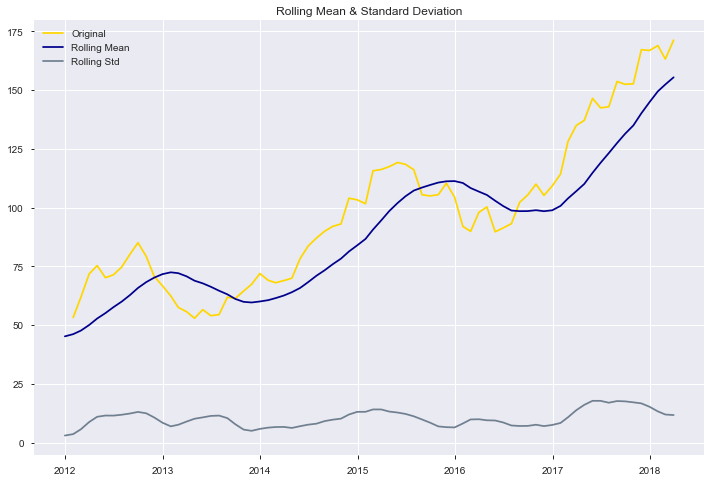

Results of Dickey-Fuller Test:
Test Statistic                  0.529191
p-value                         0.985734
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [297]:
#test the stationarity of the untransformed dataset
test_stationarity(monthly_closes.y, 12)

### Yikes, look at that p-value! Let's see if we can bump that down.

## Transforming our dataset

#### Log Transformation

The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.

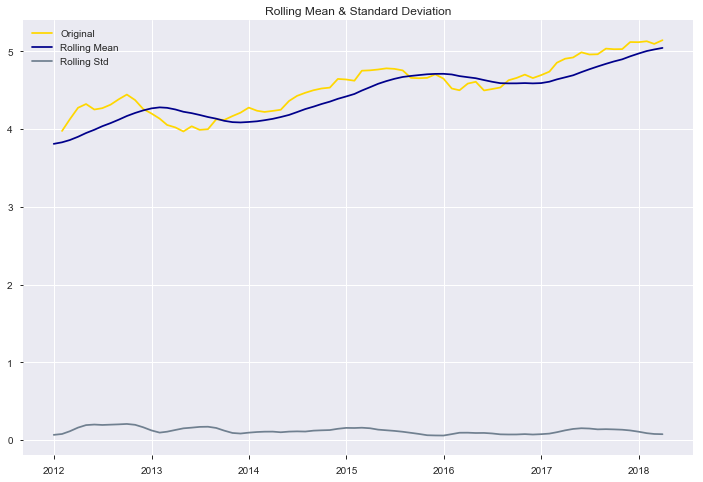

Results of Dickey-Fuller Test:
Test Statistic                 -0.771137
p-value                         0.827454
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [298]:
monthly_closes['natural_log'] = monthly_closes.y.apply(lambda x: np.log(x))  
test_stationarity(monthly_closes.natural_log, 12)

### Well... it's progress. Let's try something else.

#### First Difference

A first difference is the difference between an observation and the previous observation.

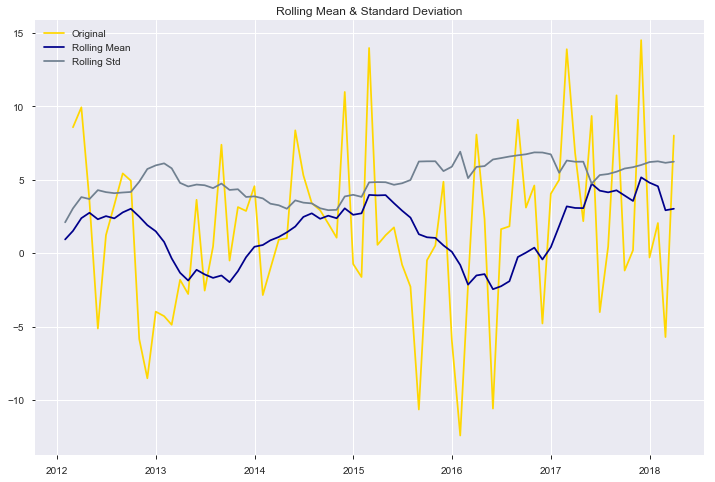

Results of Dickey-Fuller Test:
Test Statistic                -7.673486e+00
p-value                        1.570990e-11
#Lags Used                     0.000000e+00
Number of Observations Used    8.500000e+01
Critical Value (1%)           -3.509736e+00
Critical Value (5%)           -2.896195e+00
Critical Value (10%)          -2.585258e+00
dtype: float64


In [299]:
monthly_closes['first_difference'] = monthly_closes.y - monthly_closes.y.shift(1)  
test_stationarity(monthly_closes.first_difference.dropna(inplace=False),12)

### Hot damn! That's what I'm talking about! But can we go further?

#### Seasonal Difference

A seasonal difference is the difference between an observation and the previous observation from the same season.

In [300]:
monthly_closes['seasonal_difference'] = monthly_closes.y - monthly_closes.y.shift(12)

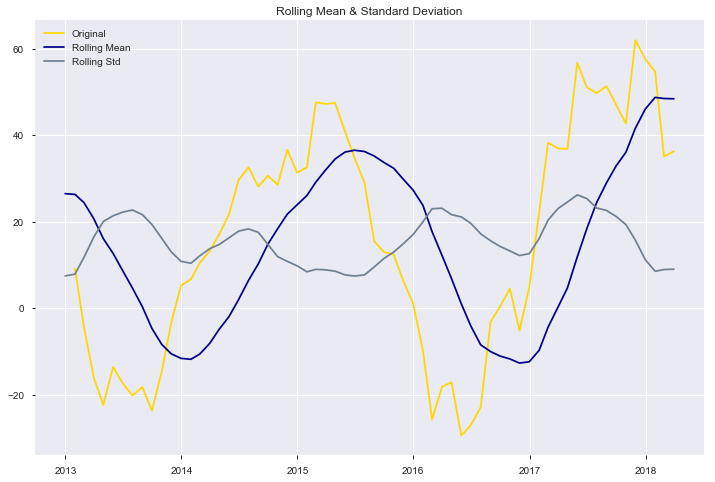

Results of Dickey-Fuller Test:
Test Statistic                 -1.963603
p-value                         0.302756
#Lags Used                     12.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [301]:
test_stationarity(monthly_closes.seasonal_difference.dropna(inplace=False), 12)

### Well, not with this one... But there's still more!

#### Seasonal Difference of the First Difference

We can do both a first difference and a season difference.

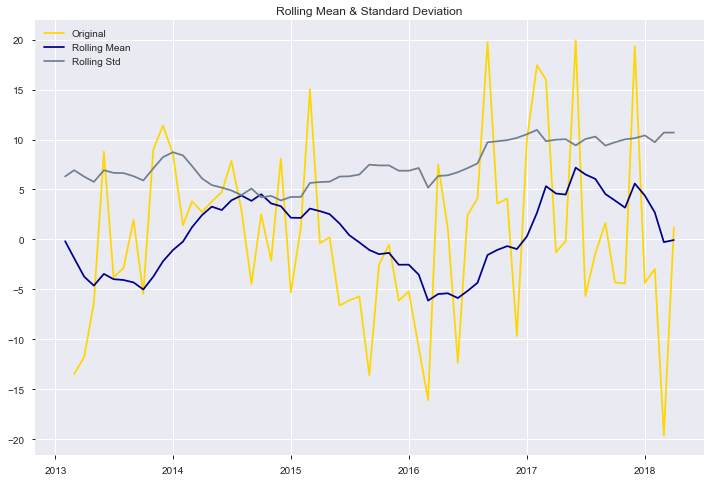

Results of Dickey-Fuller Test:
Test Statistic                 -4.350924
p-value                         0.000362
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [302]:
monthly_closes['seasonal_first_difference'] = monthly_closes.first_difference - monthly_closes.first_difference.shift(12)  
test_stationarity(monthly_closes.seasonal_first_difference.dropna(inplace=False), 12)

### Not terrible, but still not as good as the first difference! But can we go *even* further? 
###### yes...

#### Season Difference of the log first difference

Let's through in a log transformation as well.  

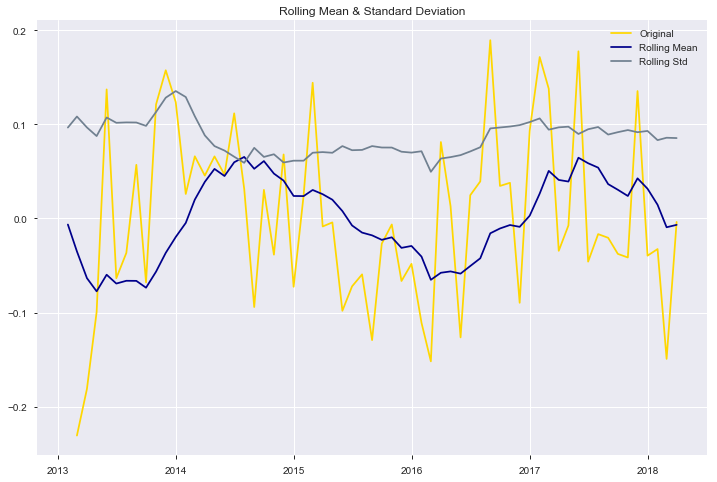

Results of Dickey-Fuller Test:
Test Statistic                 -4.501501
p-value                         0.000195
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [303]:
monthly_closes['log_first_difference'] = monthly_closes.natural_log - monthly_closes.natural_log.shift(1)  
monthly_closes['log_seasonal_first_difference'] = monthly_closes.log_first_difference - monthly_closes.log_first_difference.shift(12)  

test_stationarity(monthly_closes.log_seasonal_first_difference.dropna(inplace=False), 12)

### Still not as good as first difference. We tried!

## Plot ACF/PACF charts and find optimal parameters.

<Figure size 864x576 with 0 Axes>

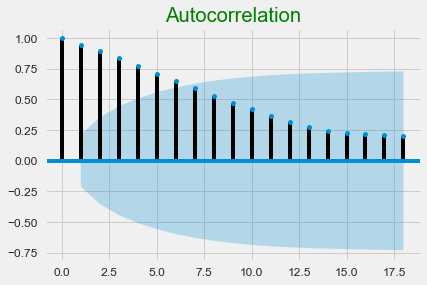

In [307]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_closes.y.iloc[1:], lags=18, ax=ax1);

<Figure size 864x576 with 0 Axes>

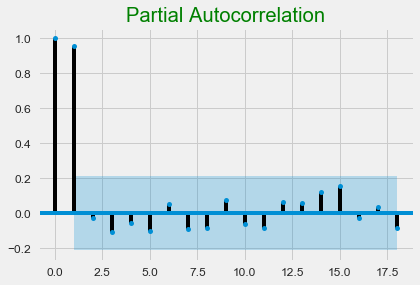

In [308]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_closes.y.iloc[1:], lags=18, ax=ax1)

In [319]:
p = d = q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)
SARIMAX: (0, 0, 0) x (0, 1, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
SARIMAX: (0, 0, 0) x (1, 0, 1, 12)
SARIMAX: (0, 0, 0) x (1, 1, 0, 12)
SARIMAX: (0, 0, 0) x (1, 1, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 0, 1) x (0, 1, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (0, 0, 1) x (1, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 1, 0, 12)
SARIMAX: (0, 0, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 0, 0, 12)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
SARIMAX: (0, 1, 0) x (1, 0, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 0, 0, 12)
SARIMAX: (0, 1, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) 

In [320]:
y = monthly_closes.y

In [321]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1034.1980917184098
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:844.969123727298
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:716.6587377318345
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:603.2053928728853
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:703.4853232096337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:640.4850170089034
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:610.5406290649762
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:602.7942658699604
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:914.0378234747011
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:742.4935429354985
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:625.0835538659891
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:525.5409054733326
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:625.2031478477832
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:614.4248075768111
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:540.9441701194881
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:525.9233477039462
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:532.7554037352612
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:465.6807681905381
ARIMA(0, 1

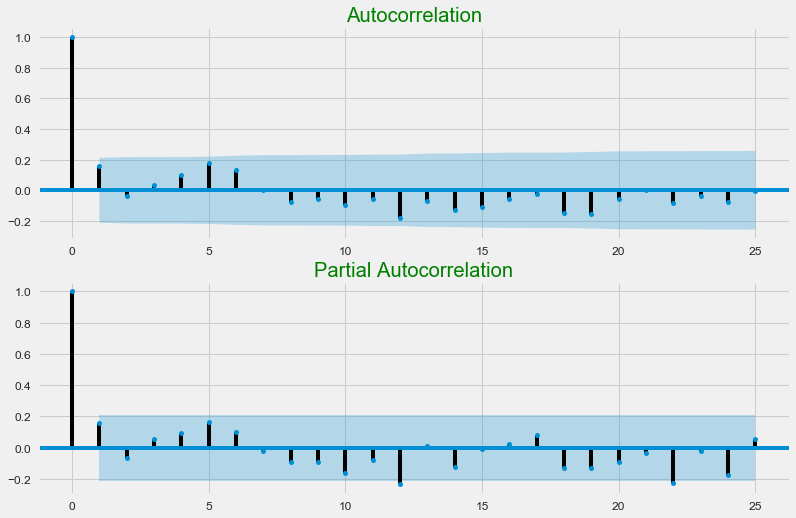

In [313]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_closes.first_difference.iloc[1:], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_closes.first_difference.iloc[1:], lags=25, ax=ax2)

In [314]:
# Use the parameters from the smallest AIC from above
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0974      0.179      0.543      0.587      -0.254       0.449
ma.S.L12      -1.0000   2.32e+04   -4.3e-05      1.000   -4.56e+04    4.56e+04
sigma2        30.4034   7.07e+05    4.3e-05      1.000   -1.38e+06    1.39e+06


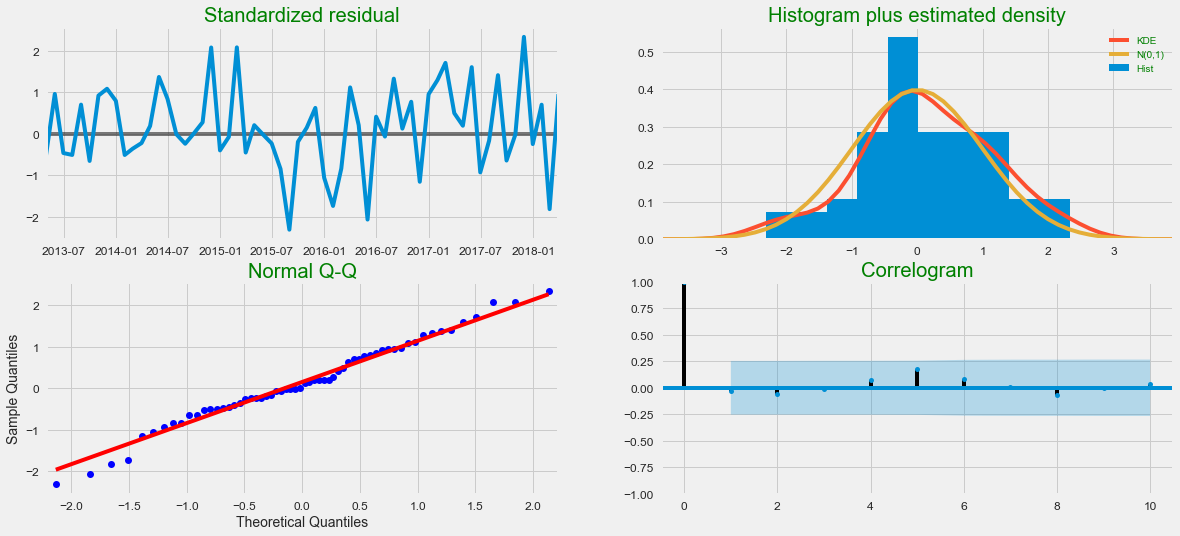

In [315]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

## Start our prediction

In [325]:
pred = results.get_prediction(start=pd.to_datetime('2017-09-30'), dynamic=True)

In [326]:
pred_ci = pred.conf_int()

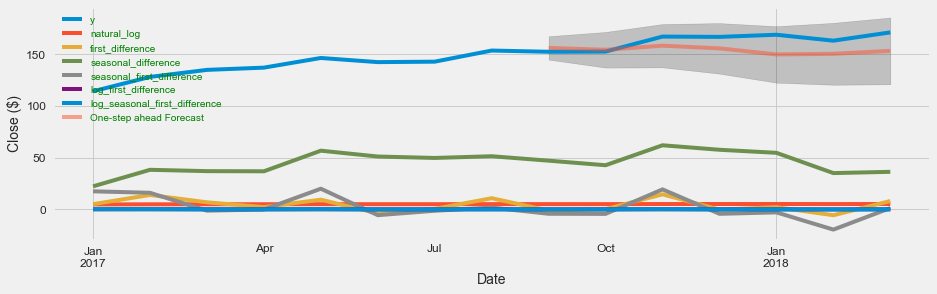

In [331]:
ax = monthly_closes['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Close ($)')
plt.legend()
plt.show()

## Set the forecast and graph it

In [332]:
# Set the forecast as the predicted mean
y_forecasted = pred.predicted_mean
y_truth = y['2017-09-30':]

#calculate the MSE for the data
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 151.91
The Root Mean Squared Error is 12.33


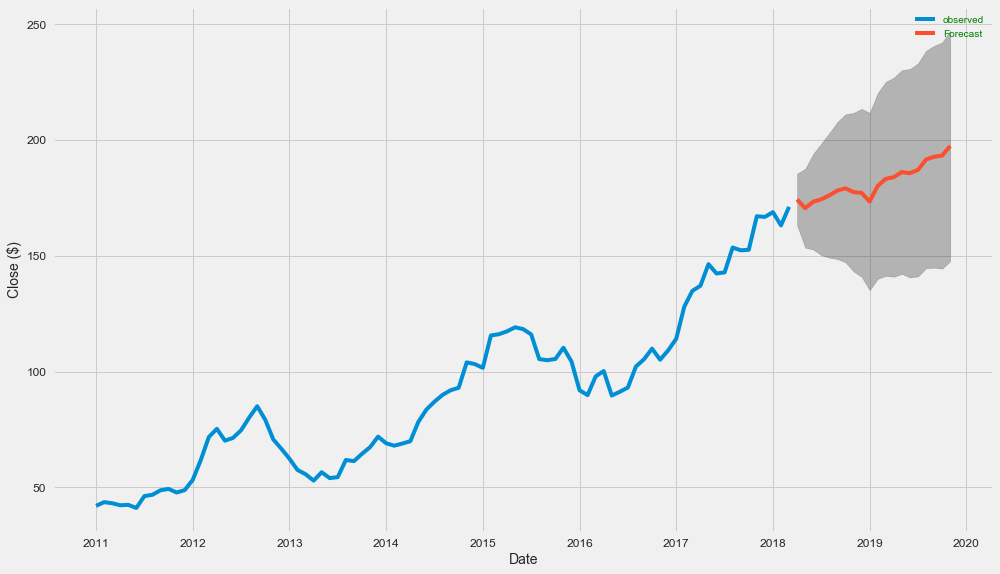

In [345]:
# Predict out to the last date that we have information on
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(15, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close ($)')
plt.legend()
plt.show()

In [334]:
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2018-03-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,20)]
future = pd.DataFrame(index=date_list, columns= monthly_closes.columns)
monthly_closes = pd.concat([monthly_closes, future])

In [337]:
results.predict().tail()

ds
2017-11-30    157.343782
2017-12-31    165.517368
2018-01-31    160.531182
2018-02-28    171.023197
2018-03-31    163.840405
Freq: M, dtype: float64

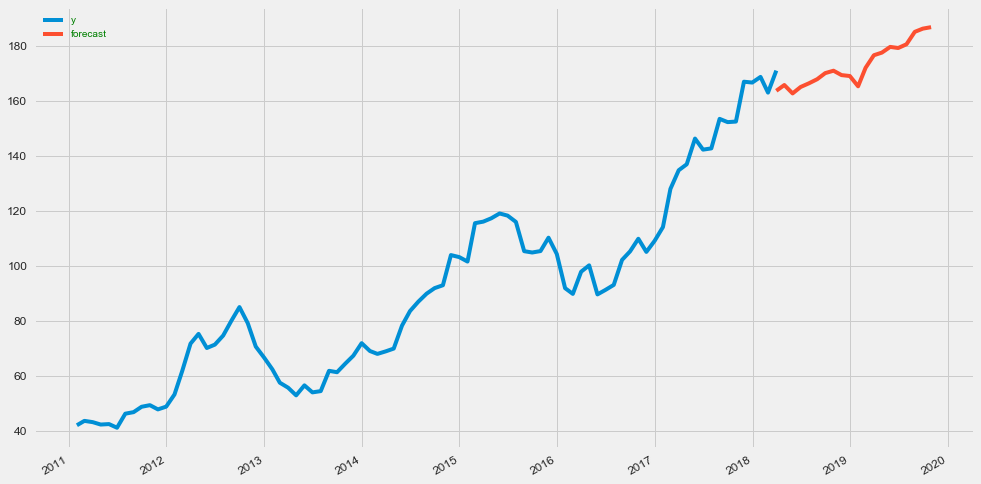

In [347]:
monthly_closes['forecast'] = results.predict(start = "2018-03-31", end = "2019-11-30", dynamic= True)  
monthly_closes[['y', 'forecast']].iloc[-122:].plot(figsize=(15, 9)) 
plt.savefig('ts_predict_future.png', bbox_inches='tight')

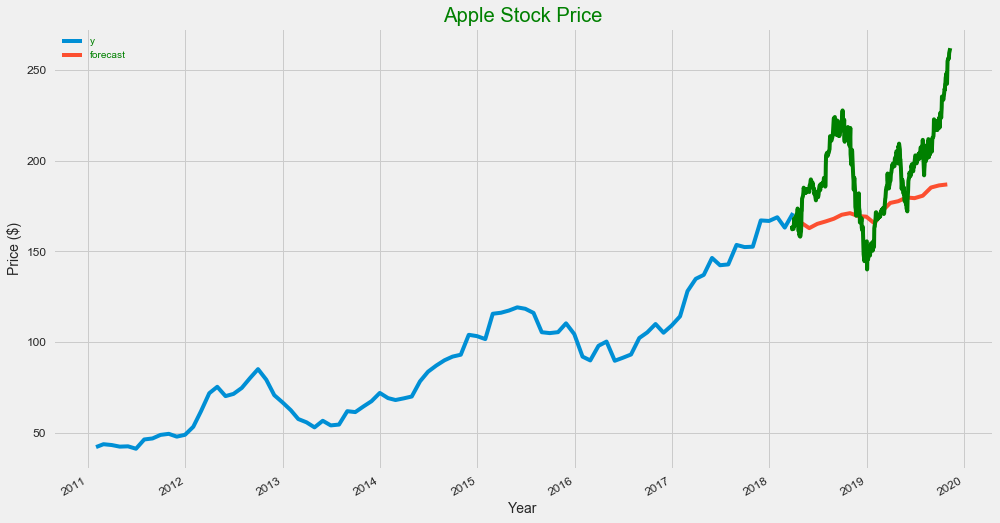

In [348]:
# Overlay our known results with our predicted results to see how well our model performed!
monthly_closes['forecast'] = results.predict(start = "2018-03-31", end = "2019-11-30", dynamic= True)  
monthly_closes[['y', 'forecast']].iloc[-122:].plot(figsize=(15, 9)) 
plt.savefig('ts_predict_future.png', bbox_inches='tight')
plt.plot(aapl_end.ds, aapl_end.y, color='green')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

##### That took a lot of time and was quite a bit of work. On top of it, much of it is fairly confusing to the average person and can be difficult to follow. Thankfully, Facebook released their open-source library, Prophet, which does much of this legwork for us. Let's see how their models compare to the one above!

# AAPL PREDICTION USING FACEBOOK PROPHET

## Gather the data via CSV from Yahoo Finance from 01/01/2011 - 11/11/2019

In [12]:
aapl = pd.read_csv('AAPL.csv')
aapl.head()

Date       Open       High        Low      Close  Adj Close  \
0  2011-01-03  46.520000  47.180000  46.405716  47.081429  40.965591   
1  2011-01-04  47.491428  47.500000  46.878571  47.327145  41.179398   
2  2011-01-05  47.078571  47.762856  47.071430  47.714287  41.516247   
3  2011-01-06  47.817142  47.892857  47.557144  47.675713  41.482681   
4  2011-01-07  47.712856  48.049999  47.414288  48.017143  41.779762   

      Volume  
0  111284600  
1   77270200  
2   63879900  
3   75107200  
4   77982800

In [13]:
# Facebook Prophet requires the date to be labeled 'ds' and our target to be labeled 'y'
aapl = aapl.rename(columns={'Date': 'ds',
                            'Adj Close': 'y'})
aapl = aapl.drop(['Open', 'High', 'Low', 'Close', 
                  'Volume'], axis=1)

In [14]:
# Facebook Prophet also requires the date column to be in datetime format
aapl['ds'] = pd.DatetimeIndex(aapl['ds'])

In [279]:
aapl.head()

ds          y
0 2011-01-03  40.965591
1 2011-01-04  41.179398
2 2011-01-05  41.516247
3 2011-01-06  41.482681
4 2011-01-07  41.779762

## First Forecast - APPL (01/01/2011-03/26/2018) Predict To 11/11/2019

In [16]:
aapl[:1819].tail()

ds           y
1814 2018-03-20  170.785858
1815 2018-03-21  166.916748
1816 2018-03-22  164.558273
1817 2018-03-23  160.747635
1818 2018-03-26  168.378662

In [17]:
# I set it to stop at 3/26 simply because that's my birthday
aapl_start = aapl[:1819]
aapl_start.tail()

ds           y
1814 2018-03-20  170.785858
1815 2018-03-21  166.916748
1816 2018-03-22  164.558273
1817 2018-03-23  160.747635
1818 2018-03-26  168.378662

In [18]:
aapl_end = aapl[1819:]
aapl_end.tail()

ds           y
2225 2019-11-05  256.360352
2226 2019-11-06  256.470001
2227 2019-11-07  259.429993
2228 2019-11-08  260.140015
2229 2019-11-11  262.200012

### Plot the data that we will train our model on, as well as the real data that we will match up with our forecast

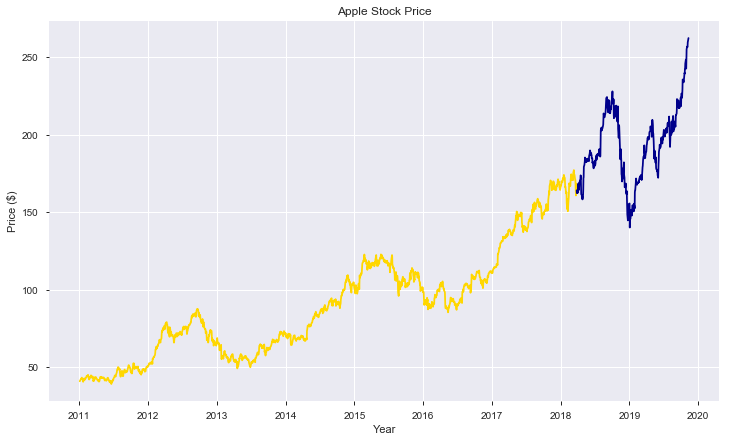

In [19]:
plt.figure(figsize=(12,7))
plt.plot(aapl_start.ds, aapl_start.y, color='gold')
plt.plot(aapl_end.ds, aapl_end.y, color='darkblue')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

### Create and fit our model

In [20]:
# Interval width at .95 to be very generous
Model_aapl = proph(interval_width=.95)

In [21]:
Model_aapl.fit(aapl_start)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [22]:
# Set the future dates to the end of our total data
future_dates = Model_aapl.make_future_dataframe(periods=595, freq='D')

In [23]:
future_dates.tail()

ds
2409 2019-11-07
2410 2019-11-08
2411 2019-11-09
2412 2019-11-10
2413 2019-11-11

In [24]:
forecast = Model_aapl.predict(future_dates)

In [25]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2409 2019-11-07  258.953783  154.018531  363.268281
2410 2019-11-08  258.901122  155.968137  364.665302
2411 2019-11-09  257.637835  155.555636  362.814383
2412 2019-11-10  257.691095  152.558332  363.880377
2413 2019-11-11  259.288902  153.675284  365.352815

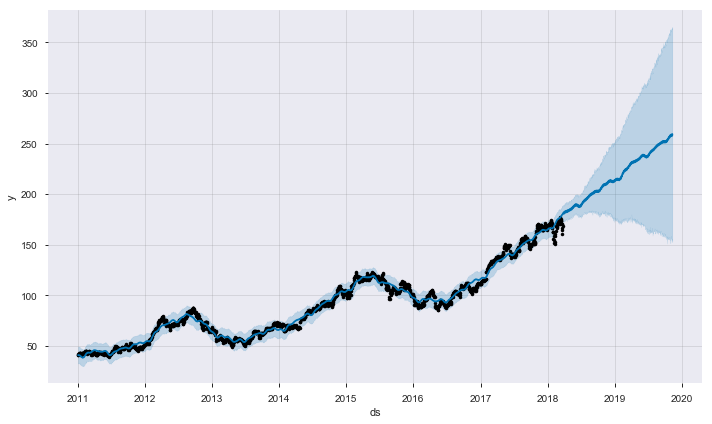

In [26]:
Model_aapl.plot(forecast, uncertainty=True);

### Plot the forecast with the real data

<Figure size 1440x1080 with 0 Axes>

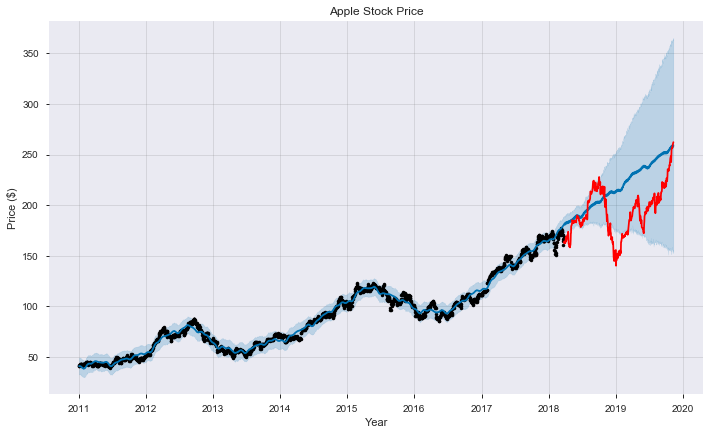

In [28]:
plt.figure(figsize=(20,15))
Model_aapl.plot(forecast, uncertainty=True)
plt.plot(aapl_end.ds, aapl_end.y, color='red')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

These results were shocking to say the least... The model's forecast was damn near spot on!

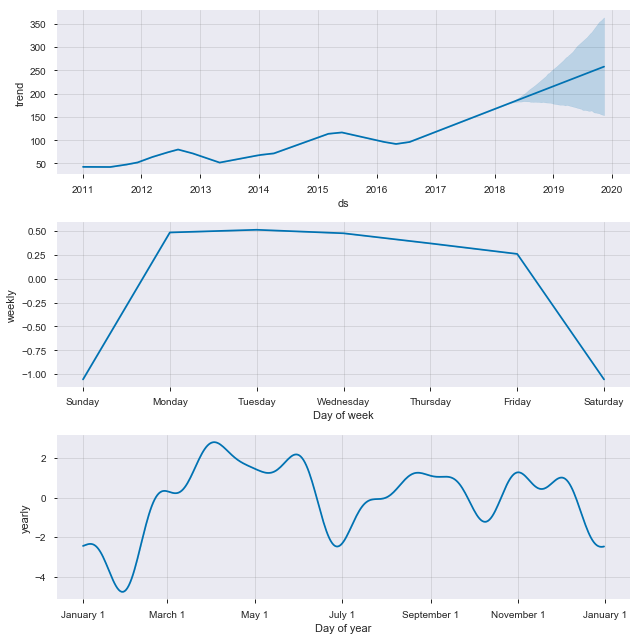

In [29]:
# Plot the trends out of interest
Model_aapl.plot_components(forecast);

In [30]:
# Run cross validation to measure forecast error
aapl_cv = cross_validation(Model_aapl, initial='1819 days', period='7 days', horizon='595 days')
aapl_cv.tail(10)

INFO:fbprophet:Making 33 forecasts with cutoffs between 2015-12-28 00:00:00 and 2016-08-08 00:00:00
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



ds       yhat  yhat_lower  yhat_upper           y     cutoff
13553 2018-03-13  52.114335  -47.821663  153.036172  175.395630 2016-08-08
13554 2018-03-14  52.199708  -51.130625  153.463321  173.904495 2016-08-08
13555 2018-03-15  52.308391  -49.851268  154.403557  174.109161 2016-08-08
13556 2018-03-16  52.276909  -50.157368  155.046447  173.495193 2016-08-08
13557 2018-03-19  52.856669  -50.943292  158.551189  170.844345 2016-08-08
13558 2018-03-20  52.856291  -49.135364  156.918265  170.785858 2016-08-08
13559 2018-03-21  52.919660  -49.926200  157.699184  166.916748 2016-08-08
13560 2018-03-22  52.984203  -47.677206  159.532165  164.558273 2016-08-08
13561 2018-03-23  52.887656  -51.738003  158.855096  160.747635 2016-08-08
13562 2018-03-26  53.166832  -50.011367  161.037277  168.378662 2016-08-08

In [31]:
aapl_cv.head()

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2015-12-29  105.316948   98.547856  111.820325  101.614525 2015-12-28
1 2015-12-30  105.490437   98.960146  111.971867  100.287575 2015-12-28
2 2015-12-31  105.728533   99.384379  112.274222   98.362572 2015-12-28
3 2016-01-04  106.581869  100.710807  113.052736   98.446655 2015-12-28
4 2016-01-05  106.673592  100.103029  113.608849   95.979675 2015-12-28

In [317]:
# View performance metrics for statistical purposes. Mostly focus on RMSE
aapl_p = performance_metrics(aapl_cv)
aapl_p.tail()

horizon          mse       rmse        mae      mape  coverage
378 589 days  9379.997346  96.850386  92.989132  0.579285  0.490301
379 590 days  9428.138589  97.098602  93.270861  0.580577  0.488557
380 591 days  9472.959246  97.329128  93.525124  0.581756  0.487832
381 592 days  9512.751169  97.533334  93.746698  0.582744  0.487307
382 595 days  9545.962516  97.703442  93.938670  0.583577  0.488154

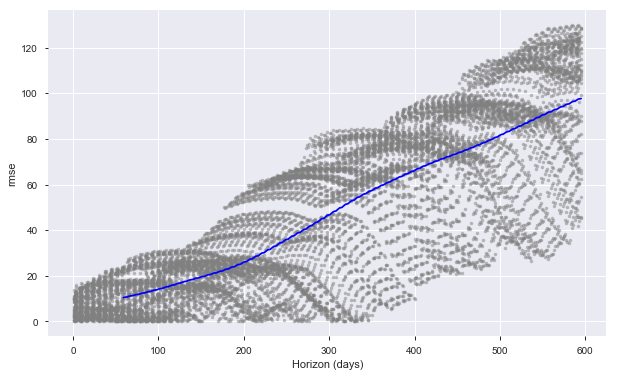

In [33]:
# Visually view the cross validation RMSE metric
fig = plot_cross_validation_metric(aapl_cv, metric='rmse')

#### Repeat the process for 5 more predictions

## Second Forecast - One Year Prediction AAPL (01/01/2011-11/11/2018) Predict To 11/11/2019

In [40]:
aapl_start_year = aapl[:1979]
aapl_start_year.tail()

ds           y
1974 2018-11-05  197.915375
1975 2018-11-06  200.055649
1976 2018-11-07  206.122986
1977 2018-11-08  205.403809
1978 2018-11-09  201.443298

In [41]:
aapl_end_year = aapl[1979:]
aapl_end_year.head()

ds           y
1979 2018-11-12  191.295761
1980 2018-11-13  189.384476
1981 2018-11-14  184.034882
1982 2018-11-15  188.576630
1983 2018-11-16  190.665237

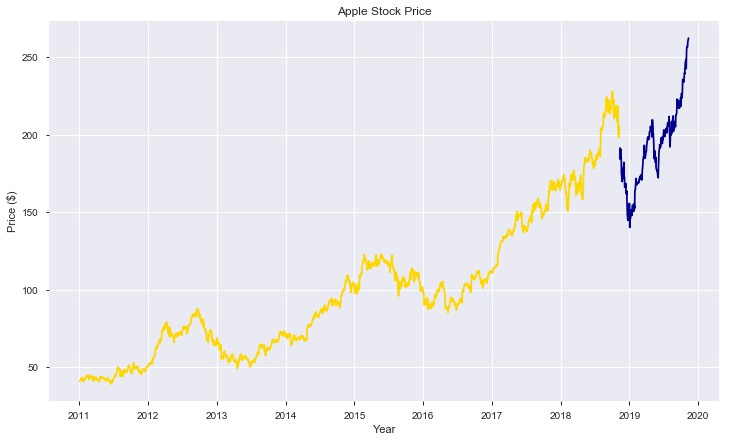

In [42]:
plt.figure(figsize=(12,7))
plt.plot(aapl_start_year.ds, aapl_start_year.y, color='gold')
plt.plot(aapl_end_year.ds, aapl_end_year.y, color='darkblue')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [44]:
Model_aapl_year = proph(interval_width=.95)

In [45]:
Model_aapl_year.fit(aapl_start_year)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [46]:
future_dates = Model_aapl_year.make_future_dataframe(periods=367, freq='D')

In [47]:
future_dates.tail()

ds
2341 2019-11-07
2342 2019-11-08
2343 2019-11-09
2344 2019-11-10
2345 2019-11-11

In [48]:
forecast = Model_aapl_year.predict(future_dates)

In [49]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2341 2019-11-07  257.137369  199.039898  313.340623
2342 2019-11-08  257.013506  200.046632  311.109531
2343 2019-11-09  255.170607  194.879873  307.952823
2344 2019-11-10  255.213608  197.455415  308.879671
2345 2019-11-11  257.303100  195.011210  312.040844

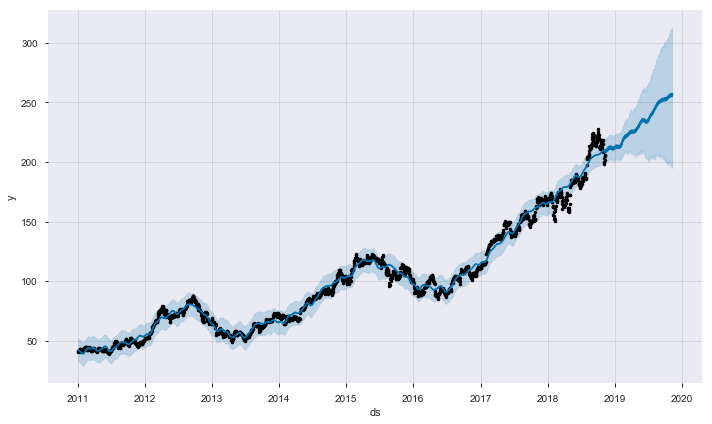

In [50]:
Model_aapl_year.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

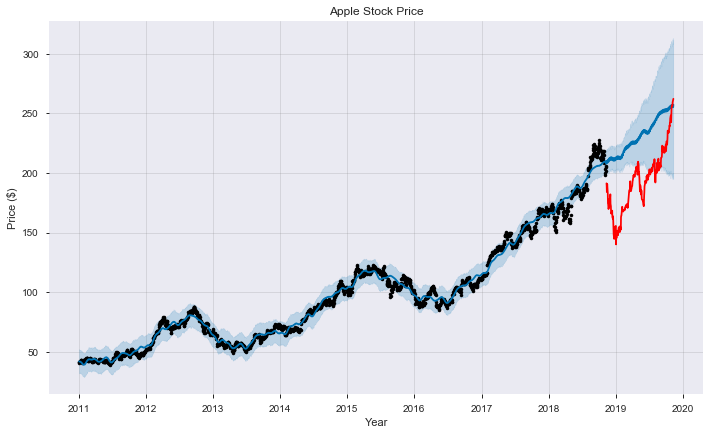

In [51]:
plt.figure(figsize=(20,15))
Model_aapl_year.plot(forecast, uncertainty=True)
plt.plot(aapl_end_year.ds, aapl_end_year.y, color='red')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

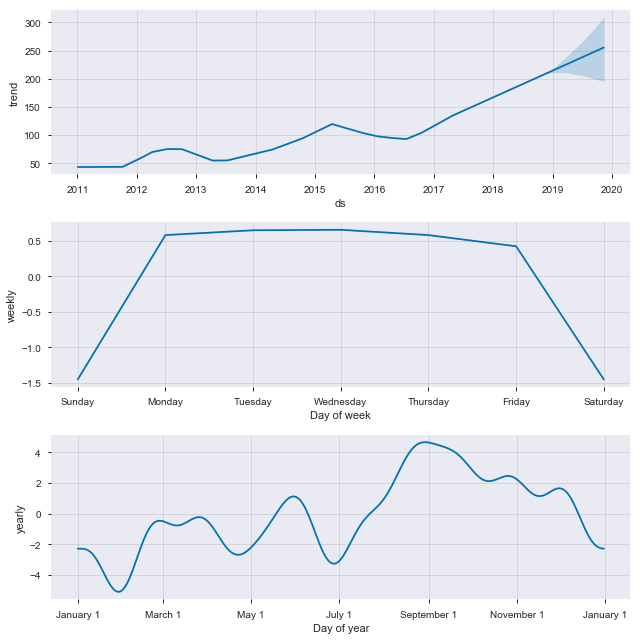

In [52]:
Model_aapl_year.plot_components(forecast);

In [53]:
aapl_year_cv = cross_validation(Model_aapl_year, initial='1095 days', period='7 days', horizon='365 days')
aapl_year_cv.tail(10)

INFO:fbprophet:Making 202 forecasts with cutoffs between 2014-01-02 00:00:00 and 2017-11-09 00:00:00
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



ds        yhat  yhat_lower  yhat_upper           y     cutoff
50890 2018-10-29  212.730416  149.506098  273.696613  208.371262 2017-11-09
50891 2018-10-30  212.887773  146.443542  275.049634  209.411926 2017-11-09
50892 2018-10-31  213.016146  145.241794  276.350515  214.870590 2017-11-09
50893 2018-11-01  213.031747  151.339627  274.646622  218.169342 2017-11-09
50894 2018-11-02  212.991952  147.620118  275.109360  203.697998 2017-11-09
50895 2018-11-05  213.441180  148.042486  276.370410  197.915375 2017-11-09
50896 2018-11-06  213.479674  147.914831  277.762001  200.055649 2017-11-09
50897 2018-11-07  213.506962  148.338642  277.861524  206.122986 2017-11-09
50898 2018-11-08  213.441550  146.562307  277.759802  205.403809 2017-11-09
50899 2018-11-09  213.342506  145.150938  276.856413  201.443298 2017-11-09

In [54]:
aapl_year_cv.head()

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2014-01-03  71.645875   67.837920   75.480157  69.545288 2014-01-02
1 2014-01-06  72.460369   68.579854   76.442224  69.924515 2014-01-02
2 2014-01-07  72.683370   68.436089   76.686775  69.424438 2014-01-02
3 2014-01-08  72.717566   68.777848   76.948765  69.864105 2014-01-02
4 2014-01-09  72.696535   68.882992   76.881771  68.971939 2014-01-02

In [55]:
aapl_year_p = performance_metrics(aapl_year_cv)
aapl_year_p.tail()

horizon          mse       rmse        mae      mape  coverage
230 361 days  1978.307397  44.478168  35.700971  0.293346  0.656506
231 362 days  1991.382769  44.624912  35.854108  0.294419  0.657340
232 363 days  2004.769724  44.774655  36.003600  0.295455  0.658655
233 364 days  2017.295826  44.914316  36.152013  0.296531  0.659655
234 365 days  2029.381037  45.048652  36.279643  0.297324  0.660908

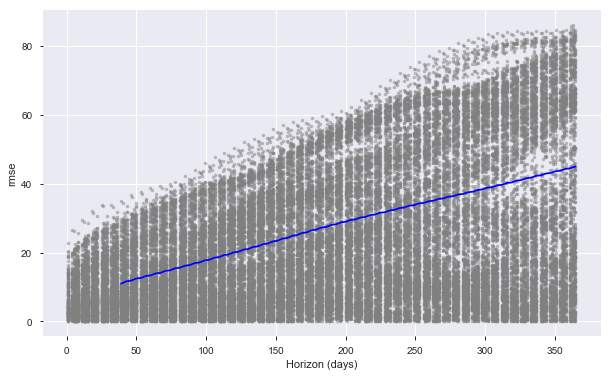

In [56]:
fig = plot_cross_validation_metric(aapl_year_cv, metric='rmse')

## Third Forecast - 6 Month Prediction AAPL (01/01/2011-05/11/2019) Predict To 11/11/2019

In [57]:
aapl[:2102].tail()

ds           y
2097 2019-05-06  206.274857
2098 2019-05-07  200.714294
2099 2019-05-08  200.753860
2100 2019-05-09  198.596924
2101 2019-05-10  195.845673

In [58]:
aapl_start_half = aapl[:2102]
aapl_start_half.tail()

ds           y
2097 2019-05-06  206.274857
2098 2019-05-07  200.714294
2099 2019-05-08  200.753860
2100 2019-05-09  198.596924
2101 2019-05-10  195.845673

In [59]:
aapl_end_half = aapl[2102:]
aapl_end_half.tail()

ds           y
2225 2019-11-05  256.360352
2226 2019-11-06  256.470001
2227 2019-11-07  259.429993
2228 2019-11-08  260.140015
2229 2019-11-11  262.200012

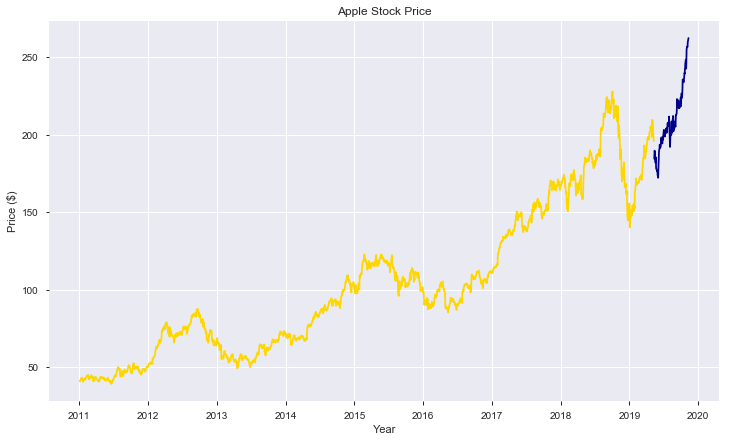

In [60]:
plt.figure(figsize=(12,7))
plt.plot(aapl_start_half.ds, aapl_start_half.y, color='gold')
plt.plot(aapl_end_half.ds, aapl_end_half.y, color='darkblue')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [61]:
Model_aapl_half = proph(interval_width=.95)

In [62]:
Model_aapl_half.fit(aapl_start_half)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [63]:
future_dates = Model_aapl_half.make_future_dataframe(periods=185, freq='D')

In [64]:
future_dates.tail()

ds
2282 2019-11-07
2283 2019-11-08
2284 2019-11-09
2285 2019-11-10
2286 2019-11-11

In [65]:
forecast = Model_aapl_half.predict(future_dates)

In [66]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2282 2019-11-07  212.955511  190.950435  236.895534
2283 2019-11-08  212.566849  190.084855  233.400148
2284 2019-11-09  209.841743  189.010908  231.355270
2285 2019-11-10  209.618883  187.758913  233.888845
2286 2019-11-11  212.008992  191.347511  234.565049

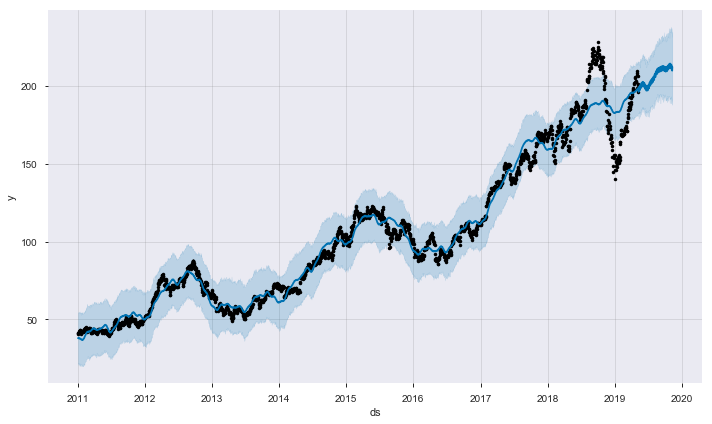

In [67]:
Model_aapl_half.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

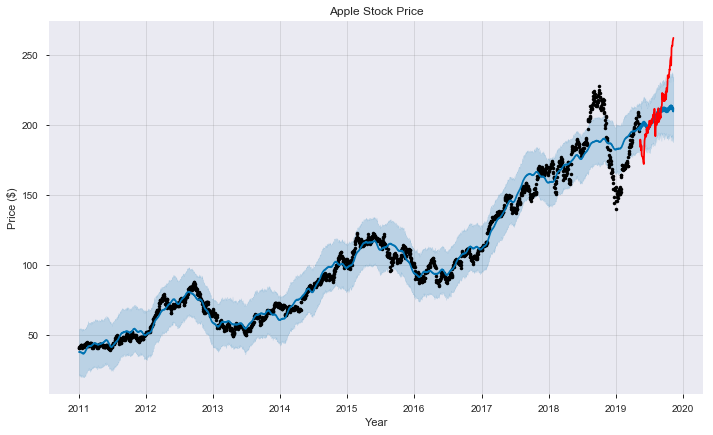

In [68]:
plt.figure(figsize=(20,15))
Model_aapl_half.plot(forecast, uncertainty=True)
plt.plot(aapl_end_half.ds, aapl_end_half.y, color='red')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

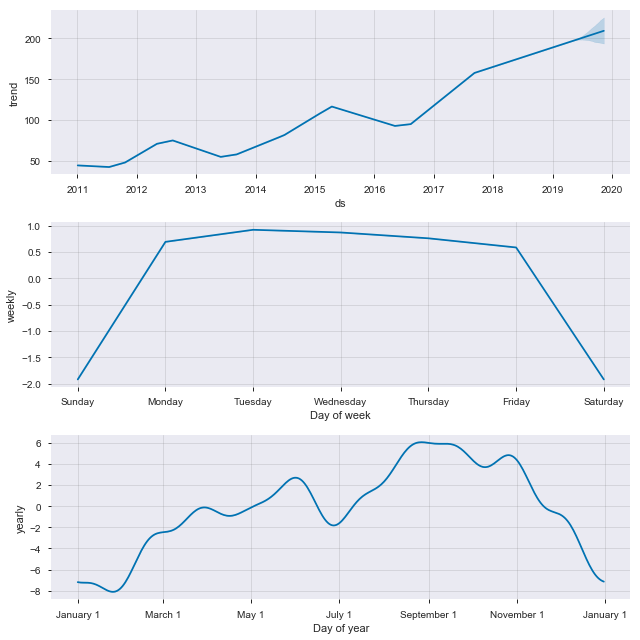

In [69]:
Model_aapl_half.plot_components(forecast);

In [70]:
aapl_half_cv = cross_validation(Model_aapl_half, initial='540 days', period='7 days', horizon='180 days')
aapl_half_cv.tail(10)

INFO:fbprophet:Making 333 forecasts with cutoffs between 2012-07-01 00:00:00 and 2018-11-11 00:00:00
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



ds        yhat  yhat_lower  yhat_upper           y     cutoff
41715 2019-04-29  228.081456  208.864465  246.388695  202.445786 2018-11-11
41716 2019-04-30  228.358627  208.141178  245.042757  198.547455 2018-11-11
41717 2019-05-01  228.582635  206.899862  245.542668  208.293274 2018-11-11
41718 2019-05-02  228.731338  209.900754  247.475549  206.937759 2018-11-11
41719 2019-05-03  228.802959  209.062336  248.000871  209.510269 2018-11-11
41720 2019-05-06  229.679662  208.727421  246.578867  206.274857 2018-11-11
41721 2019-05-07  229.994862  208.894717  247.565087  200.714294 2018-11-11
41722 2019-05-08  230.253057  208.620267  248.449859  200.753860 2018-11-11
41723 2019-05-09  230.432758  208.673728  248.790940  198.596924 2018-11-11
41724 2019-05-10  230.532788  210.339030  248.576357  195.845673 2018-11-11

In [71]:
aapl_half_cv.head()

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2012-07-02  71.775314   69.426896   74.256343  73.650322 2012-07-01
1 2012-07-03  72.265772   69.811323   74.846830  74.506752 2012-07-01
2 2012-07-05  72.773170   70.303991   75.200524  75.815620 2012-07-01
3 2012-07-06  72.850752   70.338697   75.493736  75.310966 2012-07-01
4 2012-07-09  73.905215   71.404014   76.410411  76.306618 2012-07-01

In [72]:
aapl_half_p = performance_metrics(aapl_half_cv)
aapl_half_p.tail()

horizon         mse       rmse        mae      mape  coverage
113 176 days  781.681580  27.958569  23.257346  0.233290  0.471808
114 177 days  789.061939  28.090246  23.391269  0.234794  0.474482
115 178 days  797.307933  28.236642  23.526087  0.236298  0.477560
116 179 days  807.101957  28.409540  23.683038  0.238070  0.479659
117 180 days  814.443140  28.538450  23.812700  0.239484  0.481744

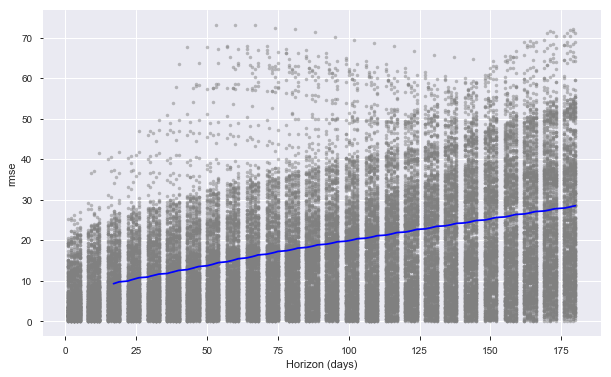

In [73]:
fig = plot_cross_validation_metric(aapl_half_cv, metric='rmse')

## Fourth Forecast - 3 Month Prediction AAPL (01/01/2011-08/11/2019) Predict To 11/11/2019

In [76]:
aapl[:2165].tail()

ds           y
2160 2019-08-05  192.031647
2161 2019-08-06  195.666885
2162 2019-08-07  197.693085
2163 2019-08-08  202.053375
2164 2019-08-09  200.388382

In [77]:
aapl_start_quarter = aapl[:2165]
aapl_start_quarter.tail()

ds           y
2160 2019-08-05  192.031647
2161 2019-08-06  195.666885
2162 2019-08-07  197.693085
2163 2019-08-08  202.053375
2164 2019-08-09  200.388382

In [78]:
aapl_end_quarter = aapl[2165:]
aapl_end_quarter.tail()

ds           y
2225 2019-11-05  256.360352
2226 2019-11-06  256.470001
2227 2019-11-07  259.429993
2228 2019-11-08  260.140015
2229 2019-11-11  262.200012

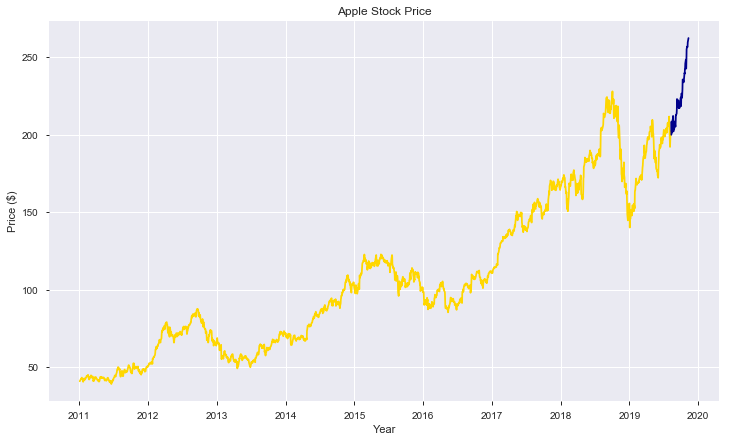

In [79]:
plt.figure(figsize=(12,7))
plt.plot(aapl_start_quarter.ds, aapl_start_quarter.y, color='gold')
plt.plot(aapl_end_quarter.ds, aapl_end_quarter.y, color='darkblue')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [80]:
Model_aapl_quarter = proph(interval_width=.95)

In [81]:
Model_aapl_quarter.fit(aapl_start_quarter)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [82]:
future_dates = Model_aapl_quarter.make_future_dataframe(periods=94, freq='D')

In [83]:
future_dates.tail()

ds
2254 2019-11-07
2255 2019-11-08
2256 2019-11-09
2257 2019-11-10
2258 2019-11-11

In [84]:
forecast = Model_aapl_quarter.predict(future_dates)

In [85]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2254 2019-11-07  205.164559  188.017161  221.529430
2255 2019-11-08  204.753965  188.075404  221.474177
2256 2019-11-09  201.984211  184.204528  220.092716
2257 2019-11-10  201.742904  184.321916  219.615248
2258 2019-11-11  204.093434  186.106034  222.601957

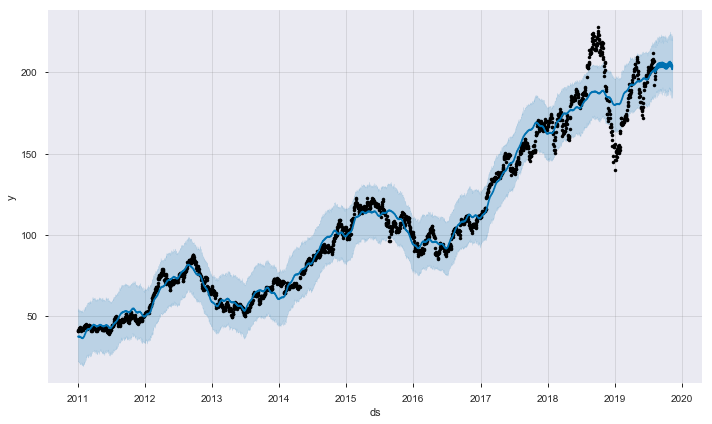

In [86]:
Model_aapl_quarter.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

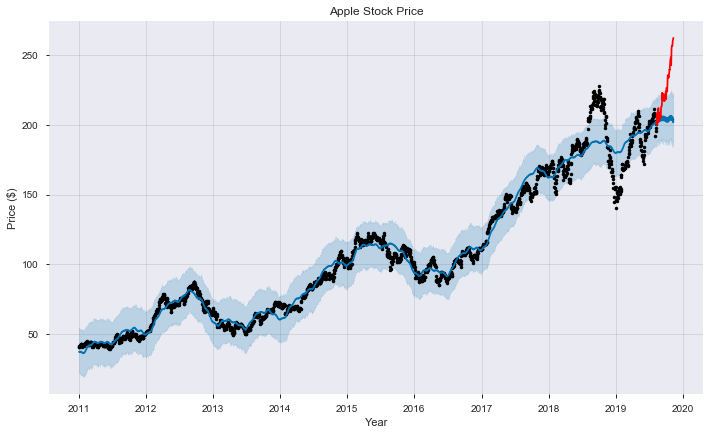

In [87]:
plt.figure(figsize=(20,15))
Model_aapl_quarter.plot(forecast, uncertainty=True)
plt.plot(aapl_end_quarter.ds, aapl_end_quarter.y, color='red')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

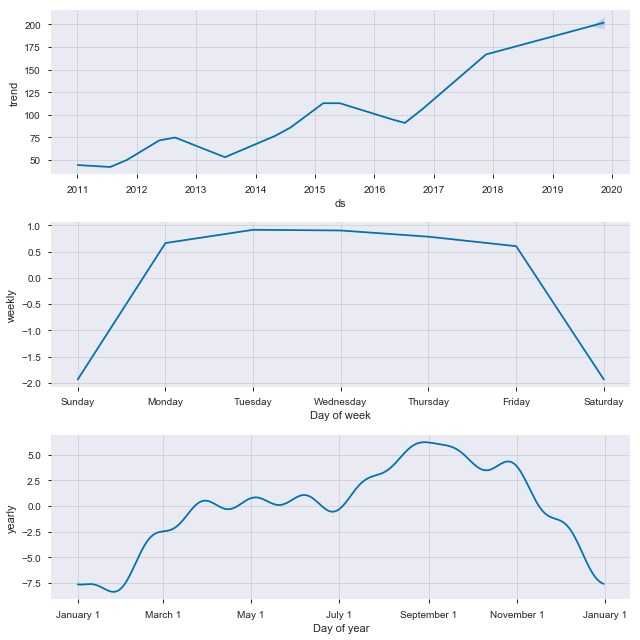

In [88]:
Model_aapl_quarter.plot_components(forecast);

## Fifth Forecast - 1 Month Prediction AAPL (01/01/2011-10/11/2019) Predict To 11/11/2019

In [89]:
aapl[:2209].tail()

ds           y
2204 2019-10-07  226.380341
2205 2019-10-08  223.728302
2206 2019-10-09  226.350433
2207 2019-10-10  229.401276
2208 2019-10-11  235.502960

In [90]:
aapl_start_month = aapl[:2209]
aapl_start_month.tail()

ds           y
2204 2019-10-07  226.380341
2205 2019-10-08  223.728302
2206 2019-10-09  226.350433
2207 2019-10-10  229.401276
2208 2019-10-11  235.502960

In [91]:
aapl_end_month = aapl[2209:]
aapl_end_month.tail()

ds           y
2225 2019-11-05  256.360352
2226 2019-11-06  256.470001
2227 2019-11-07  259.429993
2228 2019-11-08  260.140015
2229 2019-11-11  262.200012

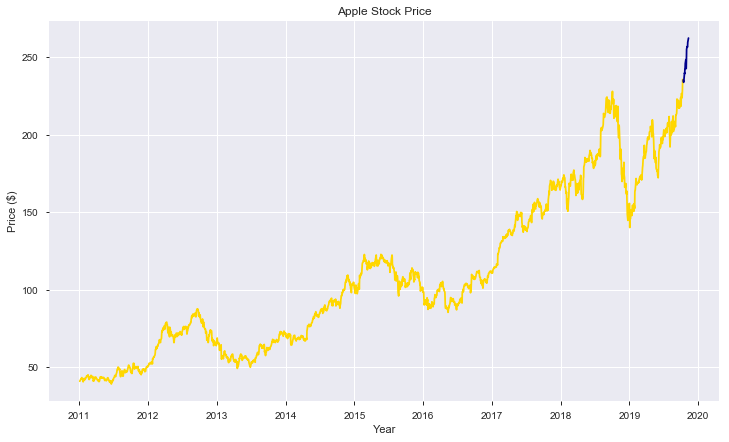

In [93]:
plt.figure(figsize=(12,7))
plt.plot(aapl_start_month.ds, aapl_start_month.y, color='gold')
plt.plot(aapl_end_month.ds, aapl_end_month.y, color='darkblue')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [94]:
Model_aapl_month = proph(interval_width=.95)

In [95]:
Model_aapl_month.fit(aapl_start_month)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [96]:
future_dates = Model_aapl_month.make_future_dataframe(periods=31, freq='D')

In [97]:
future_dates.tail()

ds
2235 2019-11-07
2236 2019-11-08
2237 2019-11-09
2238 2019-11-10
2239 2019-11-11

In [98]:
forecast = Model_aapl_month.predict(future_dates)

In [99]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2235 2019-11-07  207.263763  192.052823  224.139659
2236 2019-11-08  206.871808  190.747629  222.977399
2237 2019-11-09  203.903339  187.941547  221.886279
2238 2019-11-10  203.686313  188.108627  220.381876
2239 2019-11-11  206.261952  189.818486  221.064678

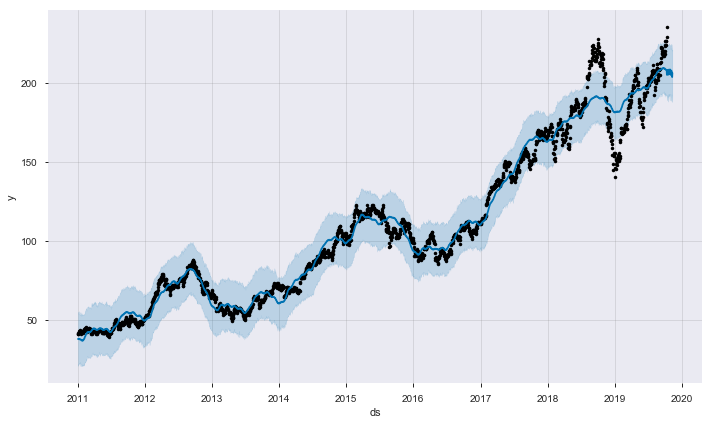

In [100]:
Model_aapl_month.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

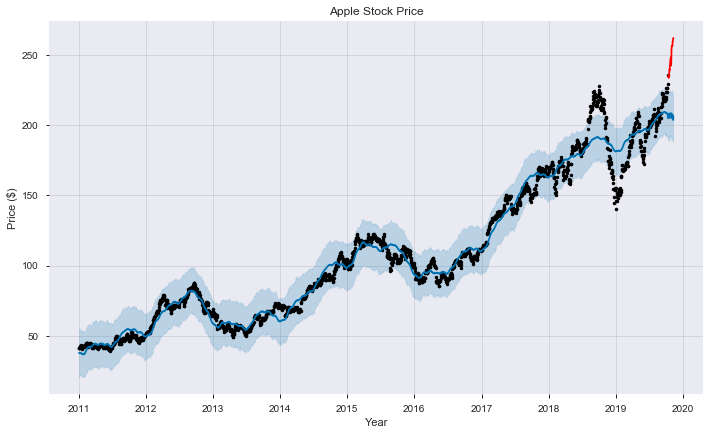

In [101]:
plt.figure(figsize=(20,15))
Model_aapl_month.plot(forecast, uncertainty=True)
plt.plot(aapl_end_month.ds, aapl_end_month.y, color='red')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

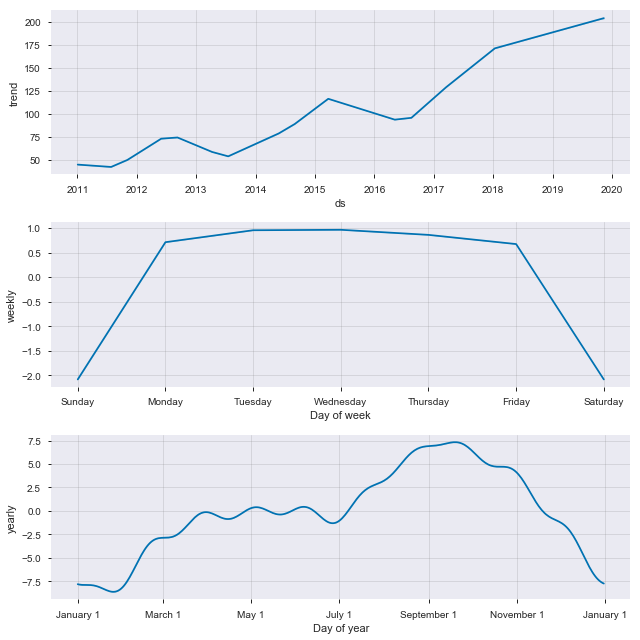

In [102]:
Model_aapl_month.plot_components(forecast);

## Sixth Forecast - 1 Week Prediction AAPL (01/01/2011-11/04/2019) Predict To 11/11/2019

In [103]:
aapl[:2225].tail()

ds           y
2220 2019-10-29  242.561752
2221 2019-10-30  242.531845
2222 2019-10-31  248.015381
2223 2019-11-01  255.054260
2224 2019-11-04  256.729218

In [104]:
aapl_start_week = aapl[:2225]
aapl_start_week.tail()

ds           y
2220 2019-10-29  242.561752
2221 2019-10-30  242.531845
2222 2019-10-31  248.015381
2223 2019-11-01  255.054260
2224 2019-11-04  256.729218

In [105]:
aapl_end_week = aapl[2225:]
aapl_end_week.head()

ds           y
2225 2019-11-05  256.360352
2226 2019-11-06  256.470001
2227 2019-11-07  259.429993
2228 2019-11-08  260.140015
2229 2019-11-11  262.200012

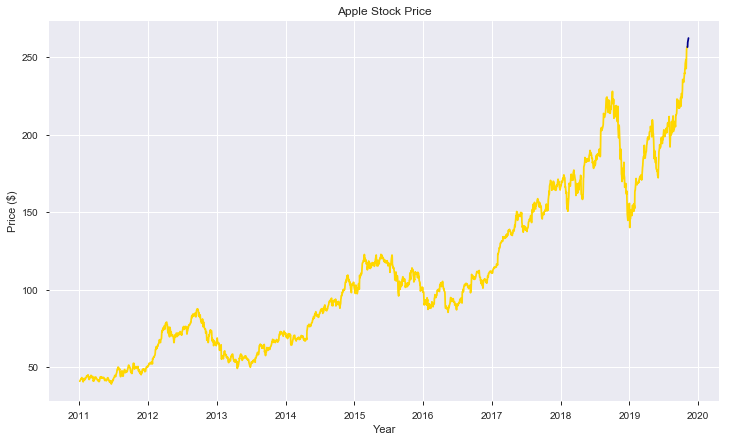

In [106]:
plt.figure(figsize=(12,7))
plt.plot(aapl_start_week.ds, aapl_start_week.y, color='gold')
plt.plot(aapl_end_week.ds, aapl_end_week.y, color='darkblue')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [107]:
Model_aapl_week = proph(interval_width=.95)

In [108]:
Model_aapl_week.fit(aapl_start_week)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [109]:
future_dates = Model_aapl_week.make_future_dataframe(periods=7, freq='D')

In [110]:
future_dates.tail()

ds
2227 2019-11-07
2228 2019-11-08
2229 2019-11-09
2230 2019-11-10
2231 2019-11-11

In [111]:
forecast = Model_aapl_week.predict(future_dates)

In [112]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2227 2019-11-07  212.998765  196.284794  229.948938
2228 2019-11-08  212.394906  196.190854  229.137947
2229 2019-11-09  209.034066  192.172486  224.639715
2230 2019-11-10  208.588410  191.926818  225.009882
2231 2019-11-11  211.181205  194.945679  227.630478

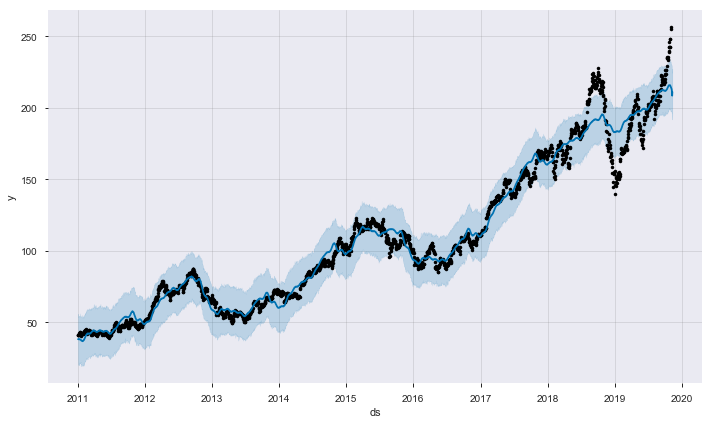

In [113]:
Model_aapl_week.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

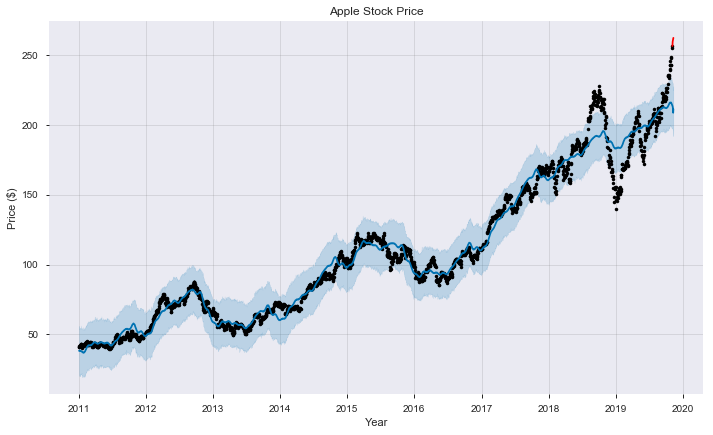

In [114]:
plt.figure(figsize=(20,15))
Model_aapl_week.plot(forecast, uncertainty=True)
plt.plot(aapl_end_week.ds, aapl_end_week.y, color='red')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

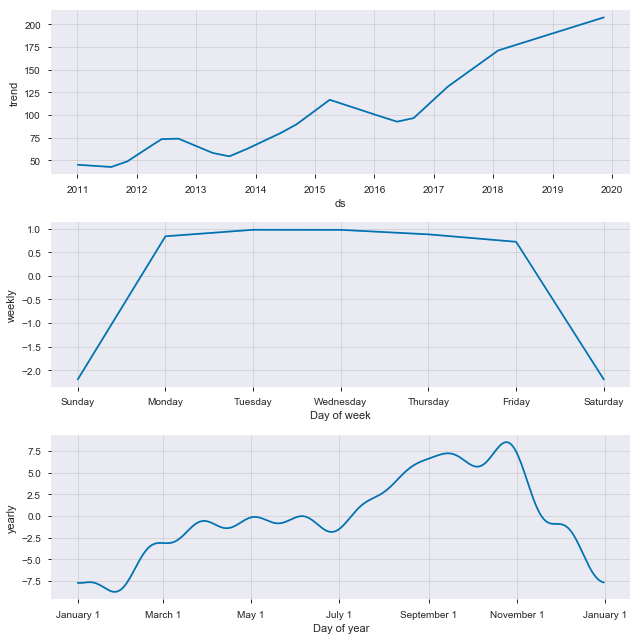

In [115]:
Model_aapl_week.plot_components(forecast);

#### It appears that the further out we try to forecast, the more accurate this model is. Specifically, forecasting out a year or more gave us the most accurate results, or, rather, the difference between prediction and reality was smallest when forecasting out a year or longer. Let's see if this holds true on a couple more stocks, using the same time periods!

# Now let's try Tesla!

## Gather the data via CSV from Yahoo Finance from 01/01/2011 - 11/11/2019

In [116]:
tsla = pd.read_csv('TSLA.csv')
tsla.head()

Date   Open       High        Low      Close  Adj Close   Volume
0  2011-01-03  26.84  27.000000  25.900000  26.620001  26.620001  1283000
1  2011-01-04  26.66  26.950001  26.020000  26.670000  26.670000  1187400
2  2011-01-05  26.48  26.900000  26.190001  26.830000  26.830000  1446700
3  2011-01-06  26.83  28.000000  26.809999  27.879999  27.879999  2061200
4  2011-01-07  28.00  28.580000  27.900000  28.240000  28.240000  2247900

In [117]:
tsla = tsla.rename(columns={'Date': 'ds',
                                    'Adj Close': 'y'})
tsla = tsla.drop(['Open', 'High', 'Low', 'Close', 
                  'Volume'], axis=1)

In [118]:
tsla['ds'] = pd.DatetimeIndex(tsla['ds'])

In [119]:
tsla.head()

ds          y
0 2011-01-03  26.620001
1 2011-01-04  26.670000
2 2011-01-05  26.830000
3 2011-01-06  27.879999
4 2011-01-07  28.240000

## First Forecast - TSLA (01/01/2011-03/26/2018) Predict To 11/11/2019

In [120]:
tsla[:1819].tail()

ds           y
1814 2018-03-20  310.549988
1815 2018-03-21  316.529999
1816 2018-03-22  309.100006
1817 2018-03-23  301.540009
1818 2018-03-26  304.179993

In [121]:
tsla_start = tsla[:1819]
tsla_start.tail()

ds           y
1814 2018-03-20  310.549988
1815 2018-03-21  316.529999
1816 2018-03-22  309.100006
1817 2018-03-23  301.540009
1818 2018-03-26  304.179993

In [122]:
tsla_end = tsla[1819:]
tsla_end.tail()

ds           y
2225 2019-11-05  317.220001
2226 2019-11-06  326.579987
2227 2019-11-07  335.540009
2228 2019-11-08  337.140015
2229 2019-11-11  345.089996

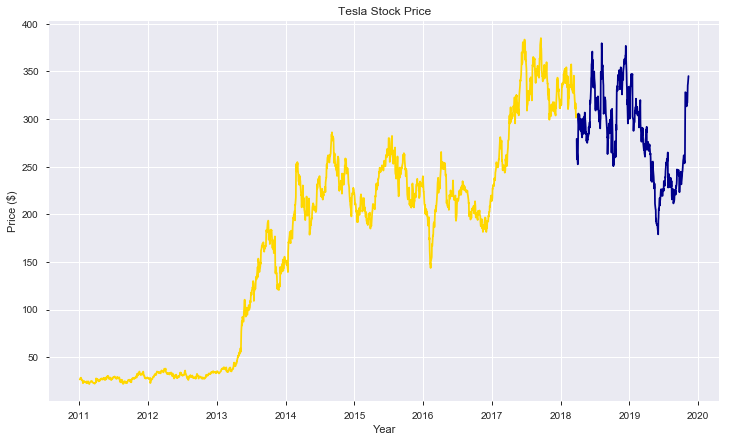

In [123]:
plt.figure(figsize=(12,7))
plt.plot(tsla_start.ds, tsla_start.y, color='gold')
plt.plot(tsla_end.ds, tsla_end.y, color='darkblue')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [124]:
Model_tsla = proph(interval_width=.95)

In [125]:
Model_tsla.fit(tsla_start)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [126]:
future_dates = Model_tsla.make_future_dataframe(periods=595, freq='D')

In [127]:
future_dates.tail()

ds
2409 2019-11-07
2410 2019-11-08
2411 2019-11-09
2412 2019-11-10
2413 2019-11-11

In [128]:
forecast = Model_tsla.predict(future_dates)

In [129]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2409 2019-11-07  548.947496  421.670719  691.158533
2410 2019-11-08  548.671430  408.506769  684.768695
2411 2019-11-09  546.501477  418.185997  690.182443
2412 2019-11-10  546.426942  414.240353  688.468849
2413 2019-11-11  548.845997  409.154755  691.860384

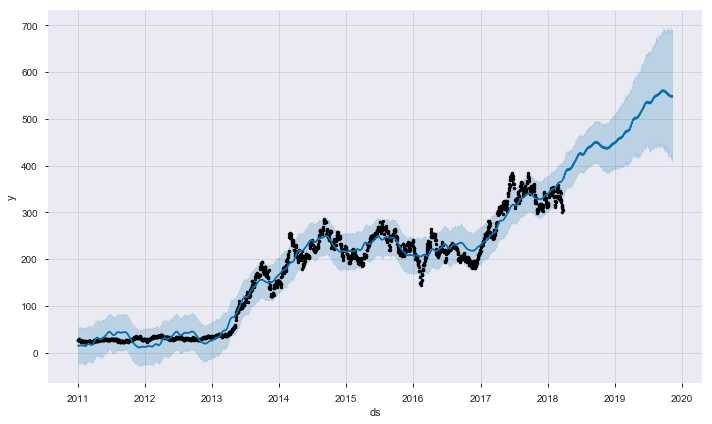

In [130]:
Model_tsla.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

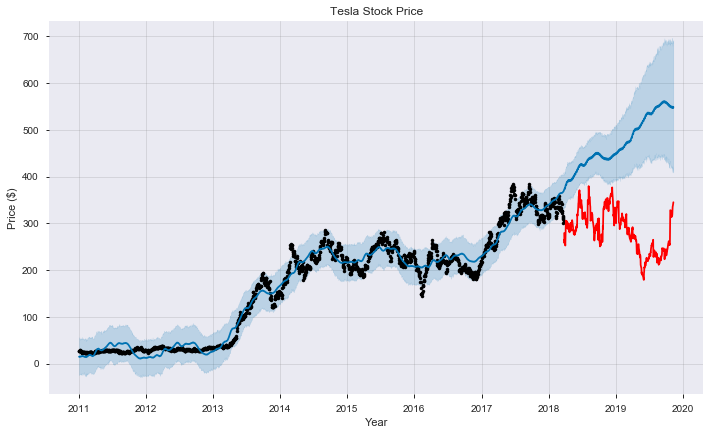

In [131]:
plt.figure(figsize=(20,15))
Model_tsla.plot(forecast, uncertainty=True)
plt.plot(tsla_end.ds, tsla_end.y, color='red')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

#### Unlike Apple, this forecast was way off the mark. Let's see how much it differs as we forecast shorter periods.

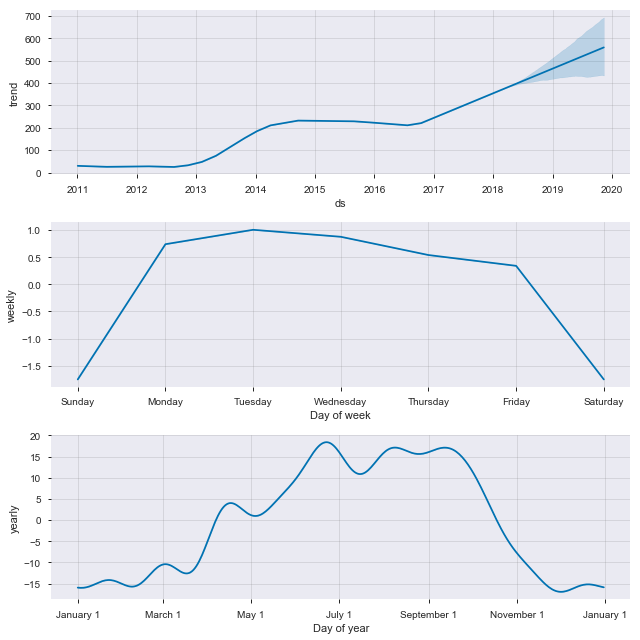

In [132]:
Model_tsla.plot_components(forecast);

## Second Forecast - One Year Prediction TSLA (01/01/2011-11/11/2018) Predict To 11/11/2019

In [133]:
tsla_start_year = tsla[:1979]
tsla_start_year.tail()

ds           y
1974 2018-11-05  341.399994
1975 2018-11-06  341.059998
1976 2018-11-07  348.160004
1977 2018-11-08  351.399994
1978 2018-11-09  350.510010

In [134]:
tsla_end_year = tsla[1979:]
tsla_end_year.head()

ds           y
1979 2018-11-12  331.279999
1980 2018-11-13  338.730011
1981 2018-11-14  344.000000
1982 2018-11-15  348.440002
1983 2018-11-16  354.309998

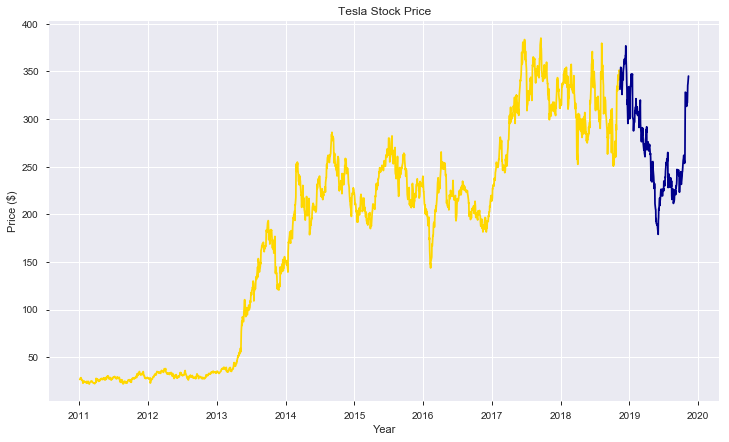

In [135]:
plt.figure(figsize=(12,7))
plt.plot(tsla_start_year.ds, tsla_start_year.y, color='gold')
plt.plot(tsla_end_year.ds, tsla_end_year.y, color='darkblue')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [136]:
Model_tsla_year = proph(interval_width=.95)

In [137]:
Model_tsla_year.fit(tsla_start_year)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [138]:
future_dates = Model_tsla_year.make_future_dataframe(periods=367, freq='D')

In [139]:
future_dates.tail()

ds
2341 2019-11-07
2342 2019-11-08
2343 2019-11-09
2344 2019-11-10
2345 2019-11-11

In [140]:
forecast = Model_tsla_year.predict(future_dates)

In [141]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2341 2019-11-07  296.943803  176.534577  416.437025
2342 2019-11-08  296.086743  175.462205  413.755378
2343 2019-11-09  294.246947  179.843517  413.573776
2344 2019-11-10  293.612676  177.403262  412.277617
2345 2019-11-11  294.335755  173.248751  413.340410

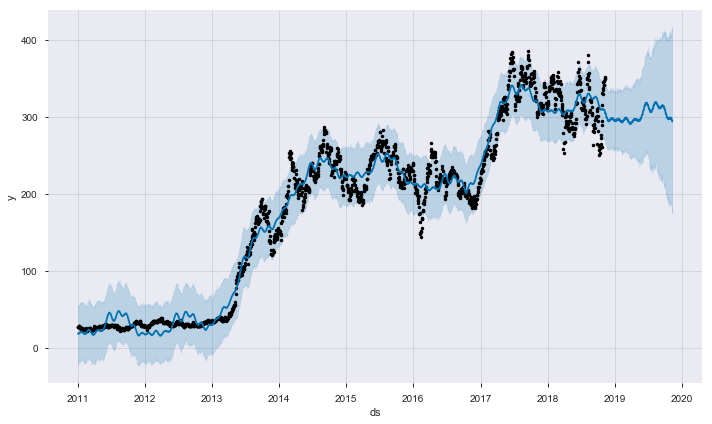

In [142]:
Model_tsla_year.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

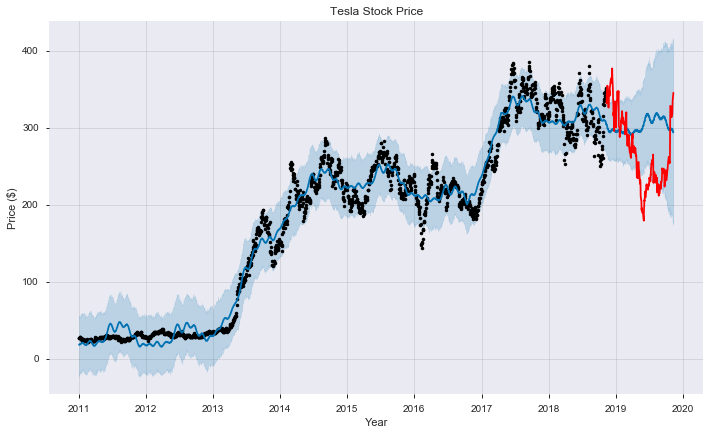

In [143]:
plt.figure(figsize=(20,15))
Model_tsla_year.plot(forecast, uncertainty=True)
plt.plot(tsla_end_year.ds, tsla_end_year.y, color='red')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

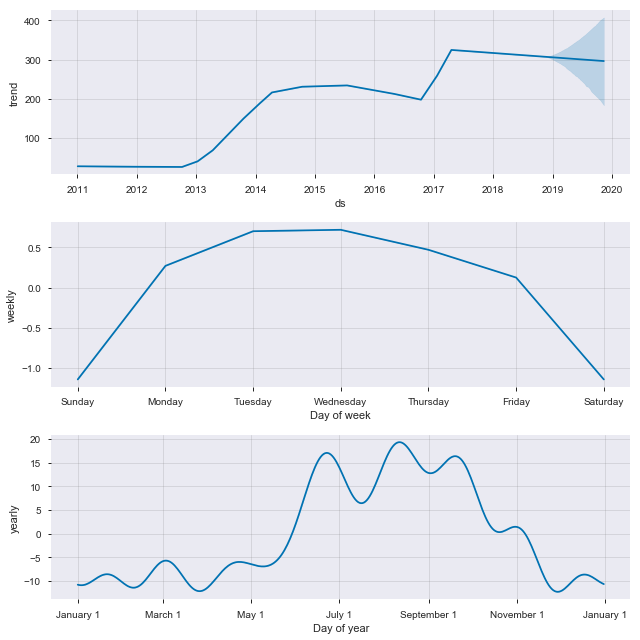

In [144]:
Model_tsla_year.plot_components(forecast);

## Third Forecast - 6 Month Prediction TSLA (01/01/2011-05/11/2019) Predict To 11/11/2019

In [145]:
tsla[:2102].tail()

ds           y
2097 2019-05-06  255.339996
2098 2019-05-07  247.059998
2099 2019-05-08  244.839996
2100 2019-05-09  241.979996
2101 2019-05-10  239.520004

In [146]:
tsla_start_half = tsla[:2102]
tsla_start_half.tail()

ds           y
2097 2019-05-06  255.339996
2098 2019-05-07  247.059998
2099 2019-05-08  244.839996
2100 2019-05-09  241.979996
2101 2019-05-10  239.520004

In [147]:
tsla_end_half = tsla[2102:]
tsla_end_half.tail()

ds           y
2225 2019-11-05  317.220001
2226 2019-11-06  326.579987
2227 2019-11-07  335.540009
2228 2019-11-08  337.140015
2229 2019-11-11  345.089996

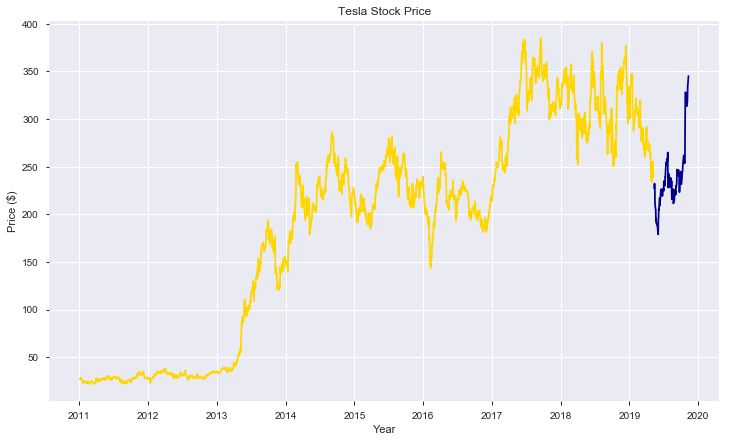

In [148]:
plt.figure(figsize=(12,7))
plt.plot(tsla_start_half.ds, tsla_start_half.y, color='gold')
plt.plot(tsla_end_half.ds, tsla_end_half.y, color='darkblue')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [149]:
Model_tsla_half = proph(interval_width=.95)

In [150]:
Model_tsla_half.fit(tsla_start_half)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [151]:
future_dates = Model_tsla_half.make_future_dataframe(periods=185, freq='D')

In [152]:
future_dates.tail()

ds
2282 2019-11-07
2283 2019-11-08
2284 2019-11-09
2285 2019-11-10
2286 2019-11-11

In [153]:
forecast = Model_tsla_half.predict(future_dates)

In [154]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2282 2019-11-07  278.833018  228.572807  327.270578
2283 2019-11-08  278.151868  228.921129  332.078242
2284 2019-11-09  277.651301  229.328042  324.390719
2285 2019-11-10  277.335601  228.045031  329.669106
2286 2019-11-11  277.670702  228.473598  327.146129

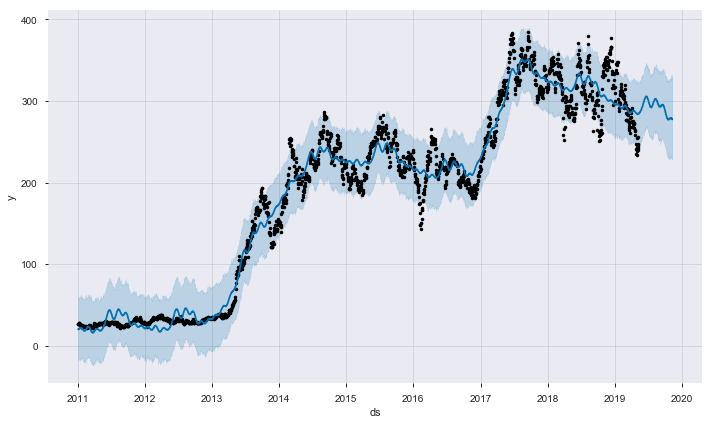

In [155]:
Model_tsla_half.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

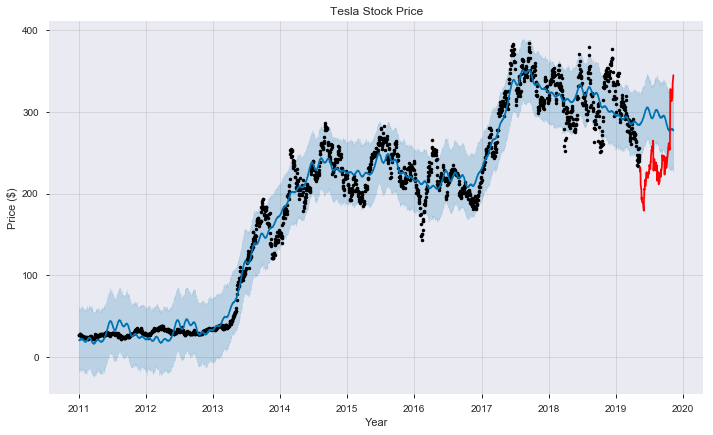

In [156]:
plt.figure(figsize=(20,15))
Model_tsla_half.plot(forecast, uncertainty=True)
plt.plot(tsla_end_half.ds, tsla_end_half.y, color='red')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

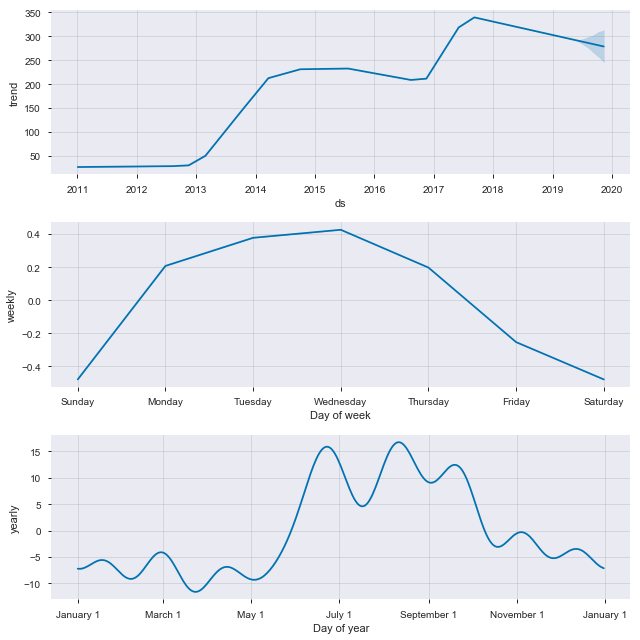

In [157]:
Model_tsla_half.plot_components(forecast);

## Fourth Forecast - 3 Month Prediction TSLA (01/01/2011-08/11/2019) Predict To 11/11/2019

In [158]:
tsla[:2165].tail()

ds           y
2160 2019-08-05  228.320007
2161 2019-08-06  230.750000
2162 2019-08-07  233.419998
2163 2019-08-08  238.300003
2164 2019-08-09  235.009995

In [159]:
tsla_start_quarter = tsla[:2165]
tsla_start_quarter.tail()

ds           y
2160 2019-08-05  228.320007
2161 2019-08-06  230.750000
2162 2019-08-07  233.419998
2163 2019-08-08  238.300003
2164 2019-08-09  235.009995

In [160]:
tsla_end_quarter = tsla[2165:]
tsla_end_quarter.tail()

ds           y
2225 2019-11-05  317.220001
2226 2019-11-06  326.579987
2227 2019-11-07  335.540009
2228 2019-11-08  337.140015
2229 2019-11-11  345.089996

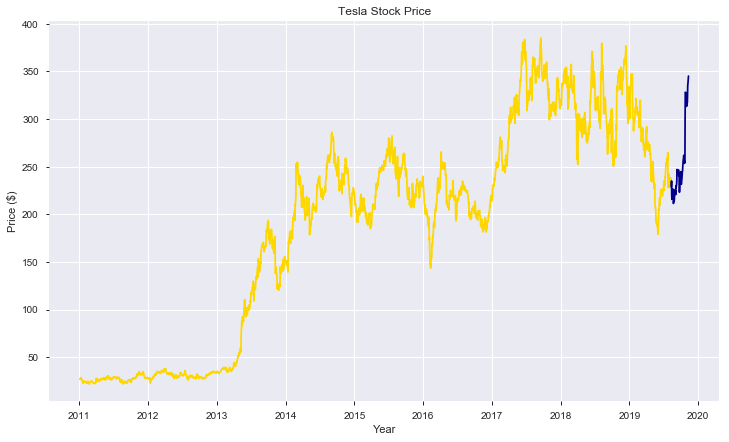

In [161]:
plt.figure(figsize=(12,7))
plt.plot(tsla_start_quarter.ds, tsla_start_quarter.y, color='gold')
plt.plot(tsla_end_quarter.ds, tsla_end_quarter.y, color='darkblue')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [162]:
Model_tsla_quarter = proph(interval_width=.95)

In [163]:
Model_tsla_quarter.fit(tsla_start_quarter)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [164]:
future_dates = Model_tsla_quarter.make_future_dataframe(periods=94, freq='D')

In [165]:
future_dates.tail()

ds
2254 2019-11-07
2255 2019-11-08
2256 2019-11-09
2257 2019-11-10
2258 2019-11-11

In [166]:
forecast = Model_tsla_quarter.predict(future_dates)

In [167]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2254 2019-11-07  239.046661  199.324395  283.886697
2255 2019-11-08  238.150972  192.864755  282.157718
2256 2019-11-09  237.637633  191.341462  281.721497
2257 2019-11-10  237.175986  191.570975  279.377016
2258 2019-11-11  237.294928  193.581405  285.476036

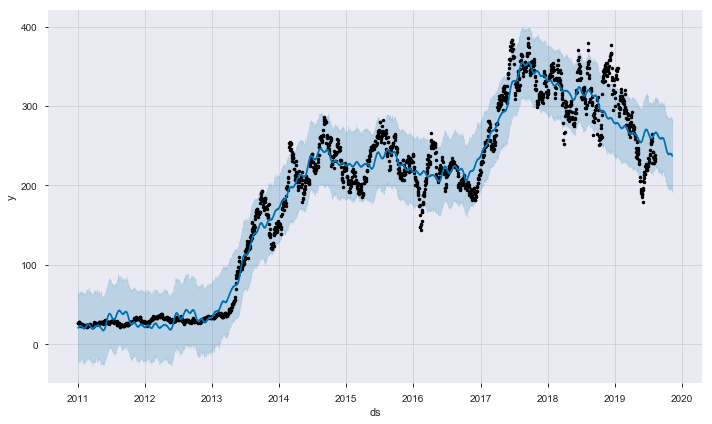

In [168]:
Model_tsla_quarter.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

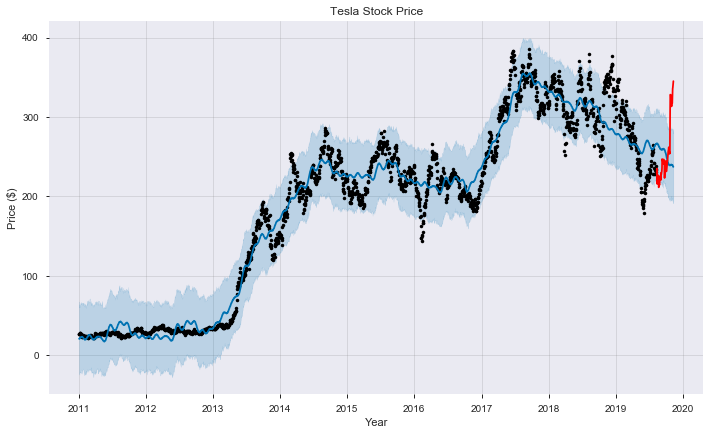

In [169]:
plt.figure(figsize=(20,15))
Model_tsla_quarter.plot(forecast, uncertainty=True)
plt.plot(tsla_end_quarter.ds, tsla_end_quarter.y, color='red')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

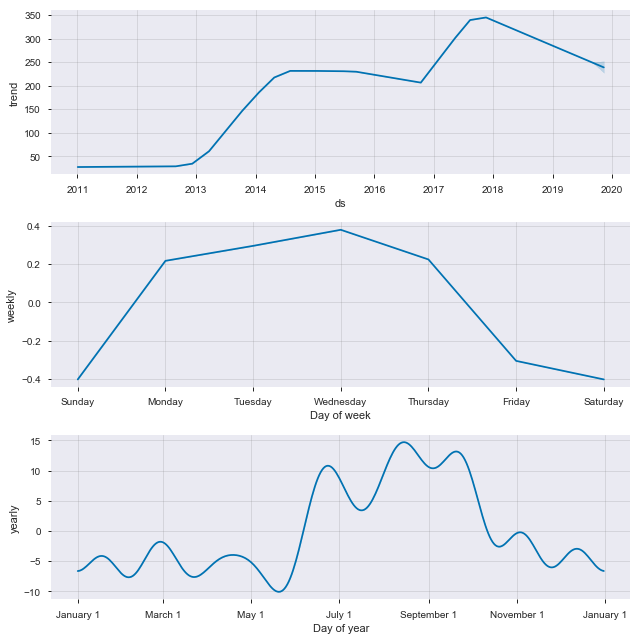

In [170]:
Model_tsla_quarter.plot_components(forecast);

## Fifth Forecast - 1 Month Prediction TSLA (01/01/2011-10/11/2019) Predict To 11/11/2019

In [171]:
tsla[:2209].tail()

ds           y
2204 2019-10-07  237.720001
2205 2019-10-08  240.050003
2206 2019-10-09  244.529999
2207 2019-10-10  244.740005
2208 2019-10-11  247.889999

In [172]:
tsla_start_month = tsla[:2209]
tsla_start_month.tail()

ds           y
2204 2019-10-07  237.720001
2205 2019-10-08  240.050003
2206 2019-10-09  244.529999
2207 2019-10-10  244.740005
2208 2019-10-11  247.889999

In [173]:
tsla_end_month = tsla[2209:]
tsla_end_month.tail()

ds           y
2225 2019-11-05  317.220001
2226 2019-11-06  326.579987
2227 2019-11-07  335.540009
2228 2019-11-08  337.140015
2229 2019-11-11  345.089996

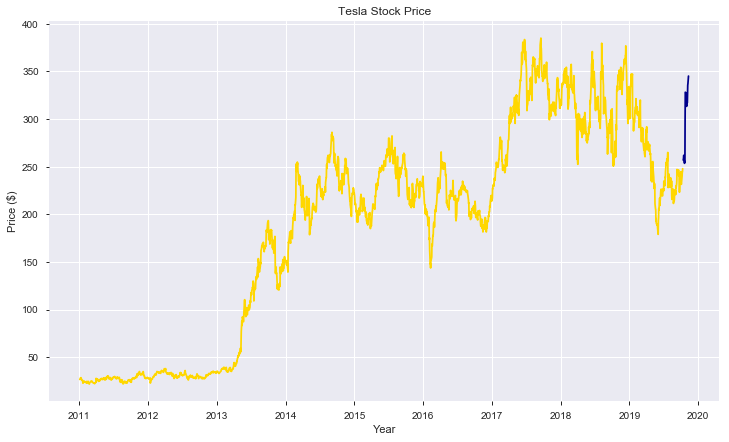

In [174]:
plt.figure(figsize=(12,7))
plt.plot(tsla_start_month.ds, tsla_start_month.y, color='gold')
plt.plot(tsla_end_month.ds, tsla_end_month.y, color='darkblue')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [175]:
Model_tsla_month = proph(interval_width=.95)

In [176]:
Model_tsla_month.fit(tsla_start_month)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [177]:
future_dates = Model_tsla_month.make_future_dataframe(periods=31, freq='D')

In [178]:
future_dates.tail()

ds
2235 2019-11-07
2236 2019-11-08
2237 2019-11-09
2238 2019-11-10
2239 2019-11-11

In [179]:
forecast = Model_tsla_month.predict(future_dates)

In [180]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2235 2019-11-07  228.634935  183.530486  273.625334
2236 2019-11-08  227.762065  183.267793  267.311753
2237 2019-11-09  227.446029  181.380365  270.859880
2238 2019-11-10  227.016444  185.688894  269.184484
2239 2019-11-11  226.952981  185.593089  267.347672

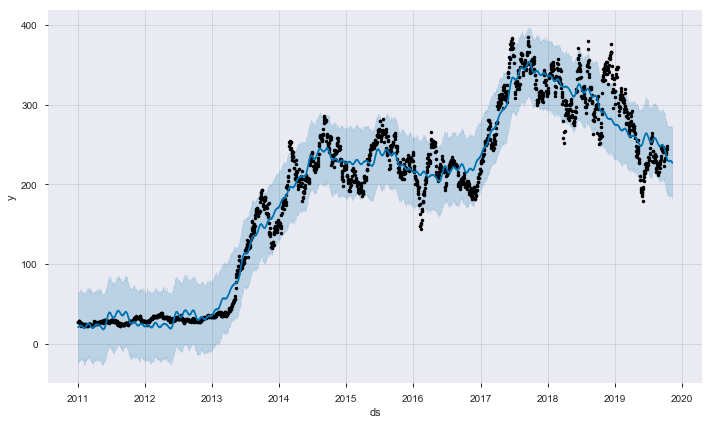

In [181]:
Model_tsla_month.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

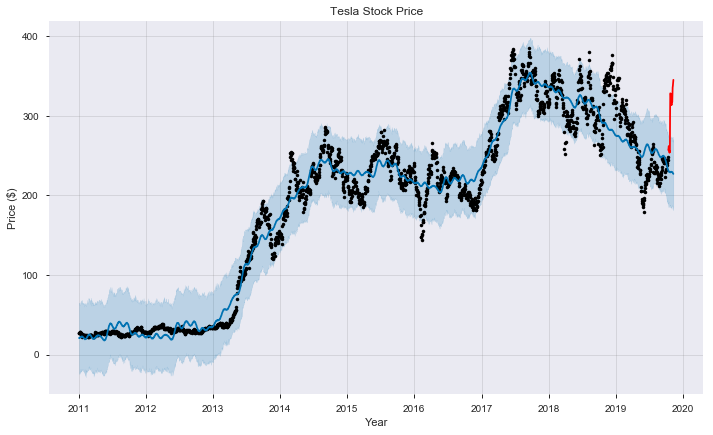

In [182]:
plt.figure(figsize=(20,15))
Model_tsla_month.plot(forecast, uncertainty=True)
plt.plot(tsla_end_month.ds, tsla_end_month.y, color='red')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

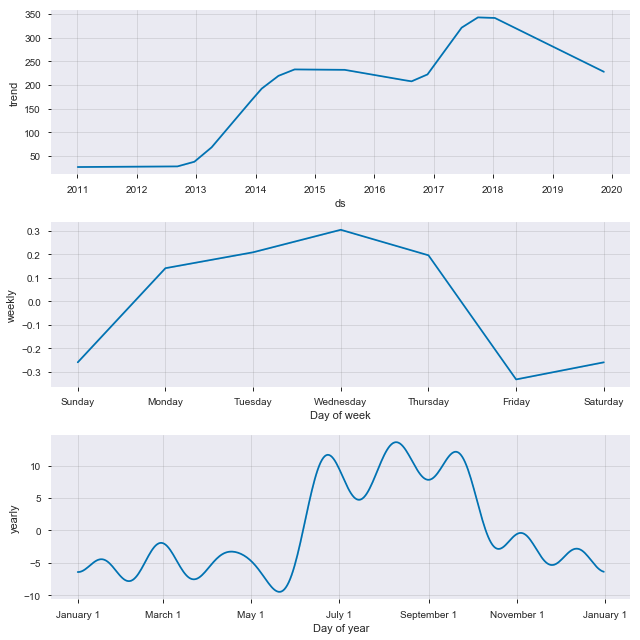

In [183]:
Model_tsla_month.plot_components(forecast);

## Sixth Forecast - 1 Week Prediction TSLA (01/01/2011-11/04/2019) Predict To 11/11/2019

In [184]:
tsla[:2225].tail()

ds           y
2220 2019-10-29  316.220001
2221 2019-10-30  315.010010
2222 2019-10-31  314.920013
2223 2019-11-01  313.309998
2224 2019-11-04  317.470001

In [185]:
tsla_start_week = tsla[:2225]
tsla_start_week.tail()

ds           y
2220 2019-10-29  316.220001
2221 2019-10-30  315.010010
2222 2019-10-31  314.920013
2223 2019-11-01  313.309998
2224 2019-11-04  317.470001

In [186]:
tsla_end_week = tsla[2225:]
tsla_end_week.head()

ds           y
2225 2019-11-05  317.220001
2226 2019-11-06  326.579987
2227 2019-11-07  335.540009
2228 2019-11-08  337.140015
2229 2019-11-11  345.089996

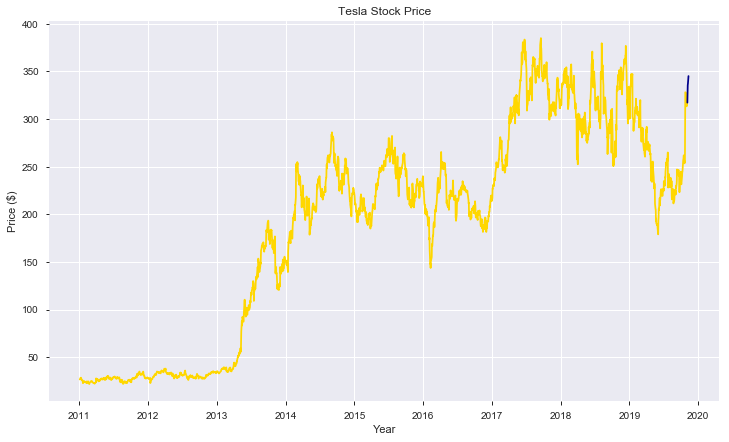

In [187]:
plt.figure(figsize=(12,7))
plt.plot(tsla_start_week.ds, tsla_start_week.y, color='gold')
plt.plot(tsla_end_week.ds, tsla_end_week.y, color='darkblue')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [188]:
Model_tsla_week = proph(interval_width=.95)

In [189]:
Model_tsla_week.fit(tsla_start_week)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [190]:
future_dates = Model_tsla_week.make_future_dataframe(periods=7, freq='D')

In [191]:
future_dates.tail()

ds
2227 2019-11-07
2228 2019-11-08
2229 2019-11-09
2230 2019-11-10
2231 2019-11-11

In [192]:
forecast = Model_tsla_week.predict(future_dates)

In [193]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2227 2019-11-07  240.160575  197.088182  282.156341
2228 2019-11-08  238.897252  198.471531  283.378676
2229 2019-11-09  237.667592  193.973825  280.774075
2230 2019-11-10  236.791133  192.730467  282.125707
2231 2019-11-11  236.801758  190.960444  281.272030

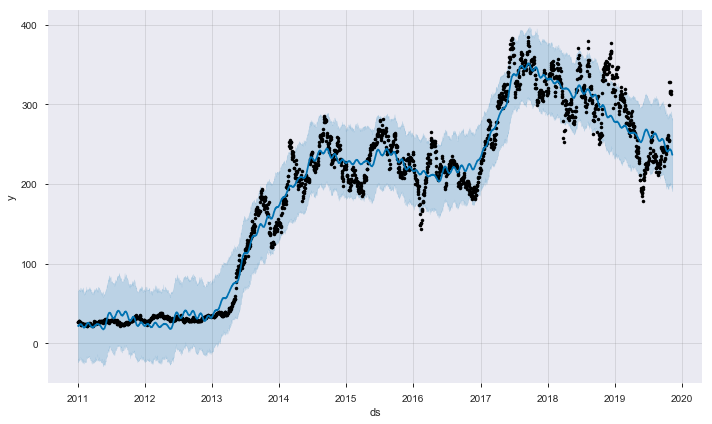

In [194]:
Model_tsla_week.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

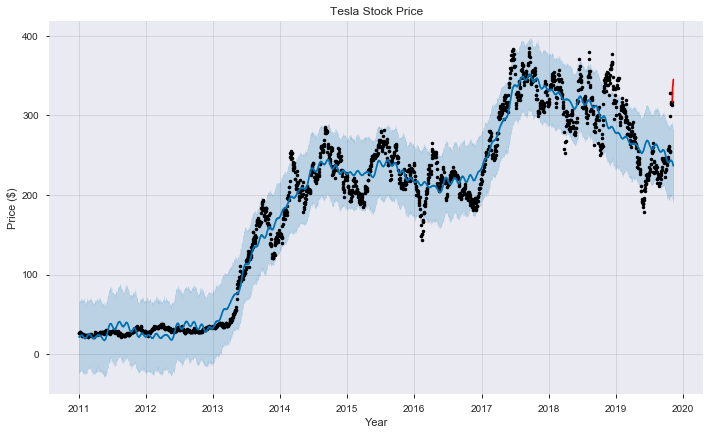

In [195]:
plt.figure(figsize=(20,15))
Model_tsla_week.plot(forecast, uncertainty=True)
plt.plot(tsla_end_week.ds, tsla_end_week.y, color='red')
plt.title('Tesla Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

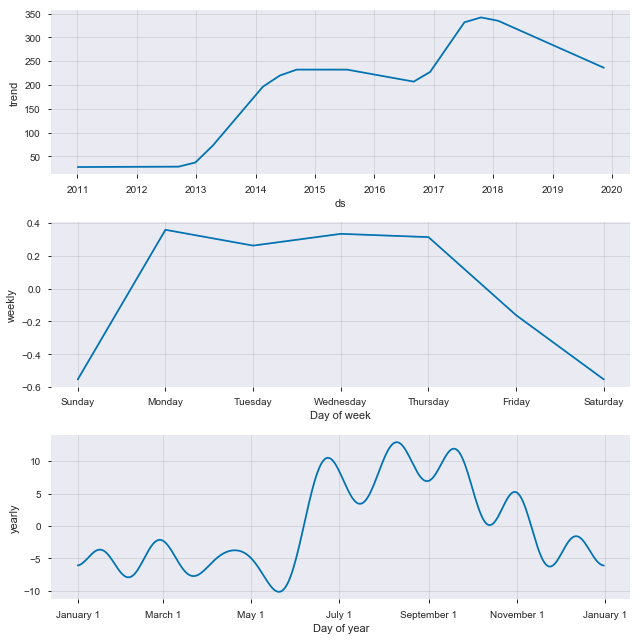

In [196]:
Model_tsla_week.plot_components(forecast);

#### Unlike Apple, Tesla seems to be difficult to forecast. The only one that was close was a one year forecast. Everything else was pretty far off the mark. Perhaps Tesla's volatility makes it difficult to forecast. 

# How about Netflix?

## Gather the data via CSV from Yahoo Finance from 01/01/2011 - 11/11/2019

In [197]:
nflx = pd.read_csv('NFLX.csv')
nflx.head()

Date       Open       High        Low      Close  Adj Close    Volume
0  2011-01-03  25.000000  25.838572  24.785715  25.487143  25.487143  39956000
1  2011-01-04  25.907143  26.414286  25.469999  25.910000  25.910000  44065700
2  2011-01-05  25.878571  26.112858  25.530001  25.675714  25.675714  31799600
3  2011-01-06  25.168571  25.670000  25.092857  25.427143  25.427143  31991400
4  2011-01-07  25.524286  25.792856  25.197144  25.614286  25.614286  22155000

In [198]:
nflx = nflx.rename(columns={'Date': 'ds',
                                    'Adj Close': 'y'})
nflx = nflx.drop(['Open', 'High', 'Low', 'Close', 
                  'Volume'], axis=1)

In [199]:
nflx['ds'] = pd.DatetimeIndex(nflx['ds'])

In [200]:
nflx.head()

ds          y
0 2011-01-03  25.487143
1 2011-01-04  25.910000
2 2011-01-05  25.675714
3 2011-01-06  25.427143
4 2011-01-07  25.614286

## First Forecast - NFLX (01/01/2011-03/26/2018) Predict To 11/11/2019

In [201]:
nflx[:1819].tail()

ds           y
1814 2018-03-20  317.500000
1815 2018-03-21  316.480011
1816 2018-03-22  306.700012
1817 2018-03-23  300.940002
1818 2018-03-26  320.350006

In [202]:
nflx_start = nflx[:1819]
nflx_start.tail()

ds           y
1814 2018-03-20  317.500000
1815 2018-03-21  316.480011
1816 2018-03-22  306.700012
1817 2018-03-23  300.940002
1818 2018-03-26  320.350006

In [203]:
nflx_end = nflx[1819:]
nflx_end.tail()

ds           y
2225 2019-11-05  288.029999
2226 2019-11-06  288.589996
2227 2019-11-07  289.570007
2228 2019-11-08  291.570007
2229 2019-11-11  294.179993

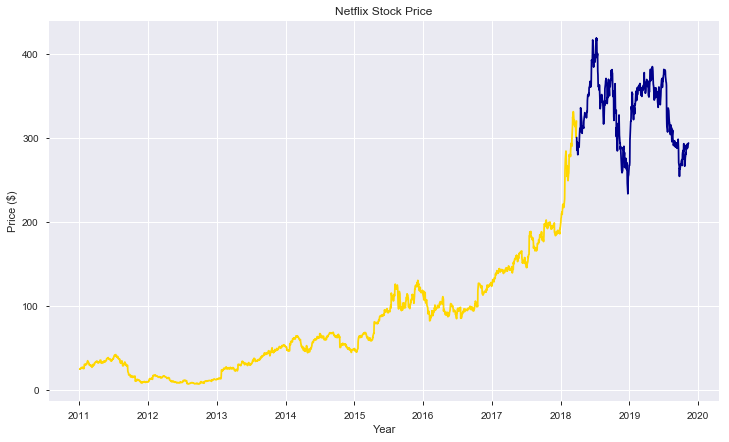

In [204]:
plt.figure(figsize=(12,7))
plt.plot(nflx_start.ds, nflx_start.y, color='gold')
plt.plot(nflx_end.ds, nflx_end.y, color='darkblue')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [205]:
Model_nflx = proph(interval_width=.95)

In [206]:
Model_nflx.fit(nflx_start)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [207]:
future_dates = Model_nflx.make_future_dataframe(periods=595, freq='D')

In [208]:
future_dates.tail()

ds
2409 2019-11-07
2410 2019-11-08
2411 2019-11-09
2412 2019-11-10
2413 2019-11-11

In [209]:
forecast = Model_nflx.predict(future_dates)

In [210]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2409 2019-11-07  417.394491  292.131271  530.797867
2410 2019-11-08  417.671716  292.247751  529.753057
2411 2019-11-09  415.197524  294.773180  526.880332
2412 2019-11-10  415.453552  292.654255  529.073610
2413 2019-11-11  418.432513  295.322562  532.460005

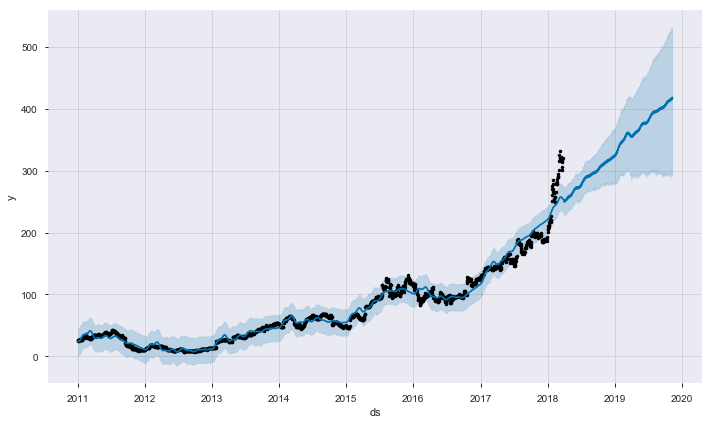

In [211]:
Model_nflx.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

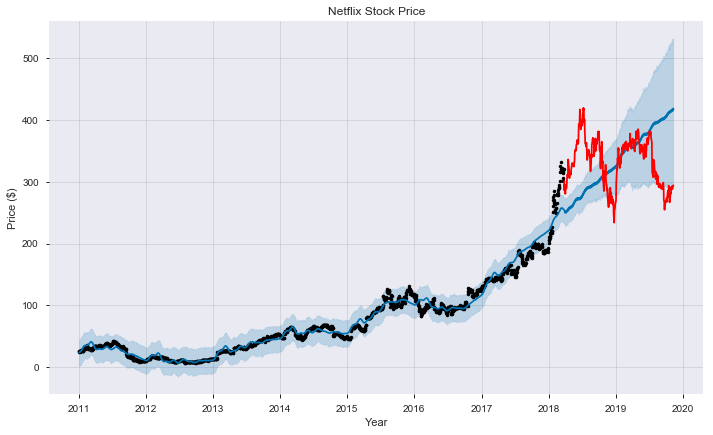

In [212]:
plt.figure(figsize=(20,15))
Model_nflx.plot(forecast, uncertainty=True)
plt.plot(nflx_end.ds, nflx_end.y, color='red')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

#### It just barely got within our generous confidence interval. Starting to seem like predicting the stock market may be up to chance.

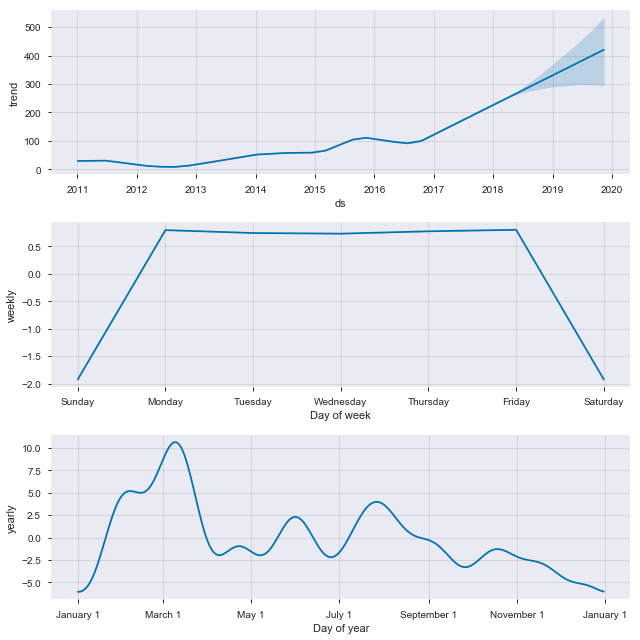

In [213]:
Model_nflx.plot_components(forecast);

## Second Forecast - One Year Prediction NFLX (01/01/2011-11/11/2018) Predict To 11/11/2019

In [214]:
nflx_start_year = nflx[:1979]
nflx_start_year.tail()

ds           y
1974 2018-11-05  315.440002
1975 2018-11-06  310.839996
1976 2018-11-07  327.500000
1977 2018-11-08  317.920013
1978 2018-11-09  303.470001

In [215]:
nflx_end_year = nflx[1979:]
nflx_end_year.head()

ds           y
1979 2018-11-12  294.070007
1980 2018-11-13  294.399994
1981 2018-11-14  286.730011
1982 2018-11-15  290.059998
1983 2018-11-16  286.209991

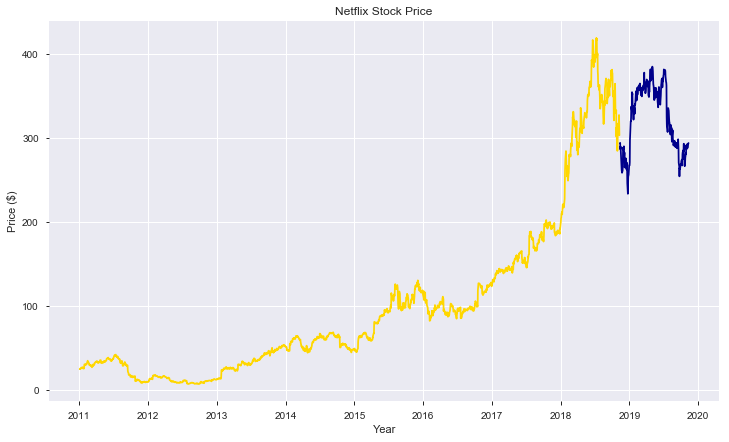

In [216]:
plt.figure(figsize=(12,7))
plt.plot(nflx_start_year.ds, nflx_start_year.y, color='gold')
plt.plot(nflx_end_year.ds, nflx_end_year.y, color='darkblue')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [217]:
Model_nflx_year = proph(interval_width=.95)

In [218]:
Model_nflx_year.fit(nflx_start_year)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [219]:
future_dates = Model_nflx_year.make_future_dataframe(periods=367, freq='D')

In [220]:
future_dates.tail()

ds
2341 2019-11-07
2342 2019-11-08
2343 2019-11-09
2344 2019-11-10
2345 2019-11-11

In [221]:
forecast = Model_nflx_year.predict(future_dates)

In [222]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2341 2019-11-07  535.965765  480.947318  602.911207
2342 2019-11-08  536.690840  482.956423  601.380885
2343 2019-11-09  532.155417  474.724911  597.229129
2344 2019-11-10  533.140174  476.007930  600.580477
2345 2019-11-11  539.628221  487.303166  601.085273

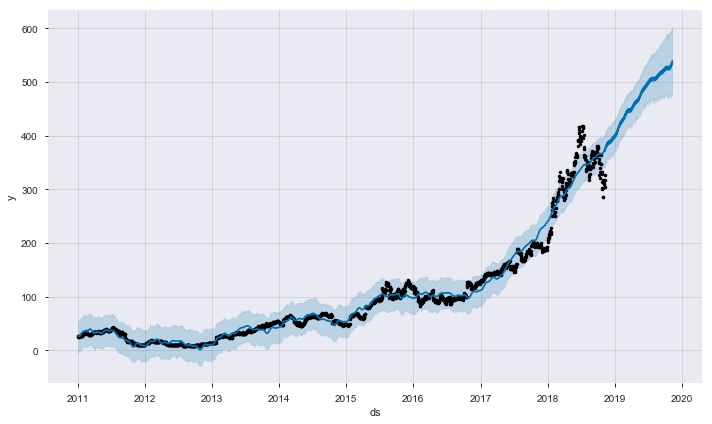

In [223]:
Model_nflx_year.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

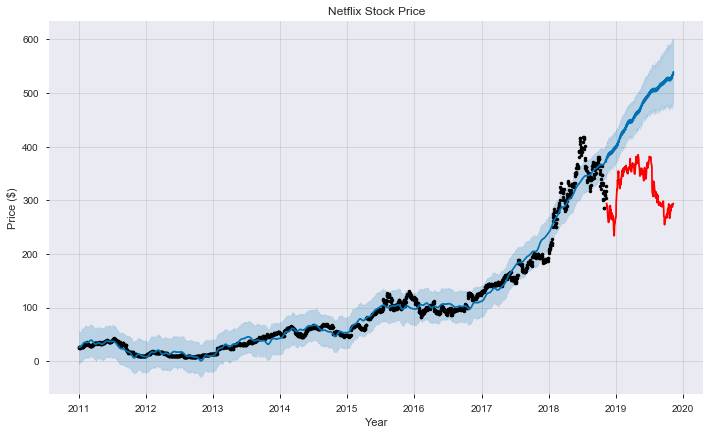

In [224]:
plt.figure(figsize=(20,15))
Model_nflx_year.plot(forecast, uncertainty=True)
plt.plot(nflx_end_year.ds, nflx_end_year.y, color='red')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

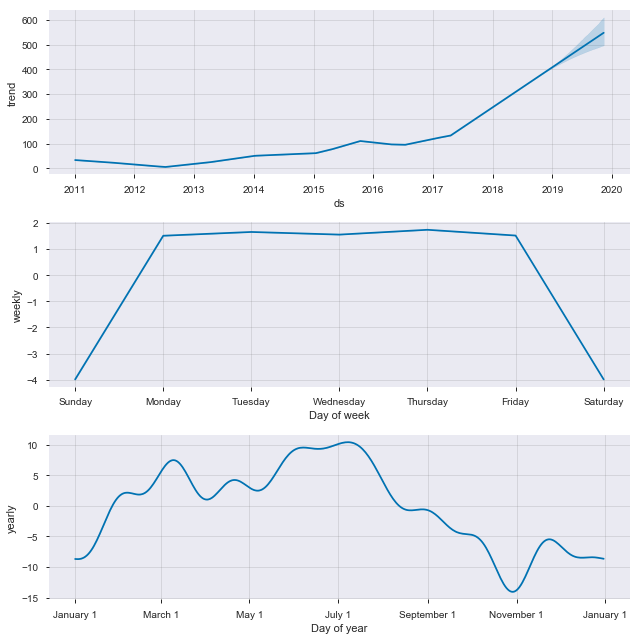

In [225]:
Model_nflx_year.plot_components(forecast);

## Third Forecast - 6 Month Prediction NFLX (01/01/2011-05/11/2019) Predict To 11/11/2019

In [226]:
nflx[:2102].tail()

ds           y
2097 2019-05-06  378.670013
2098 2019-05-07  370.459991
2099 2019-05-08  364.369995
2100 2019-05-09  362.750000
2101 2019-05-10  361.040009

In [227]:
nflx_start_half = nflx[:2102]
nflx_start_half.tail()

ds           y
2097 2019-05-06  378.670013
2098 2019-05-07  370.459991
2099 2019-05-08  364.369995
2100 2019-05-09  362.750000
2101 2019-05-10  361.040009

In [228]:
nflx_end_half = nflx[2102:]
nflx_end_half.tail()

ds           y
2225 2019-11-05  288.029999
2226 2019-11-06  288.589996
2227 2019-11-07  289.570007
2228 2019-11-08  291.570007
2229 2019-11-11  294.179993

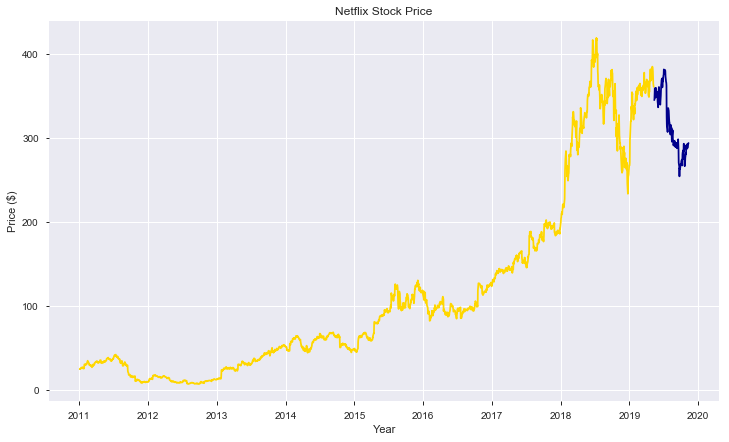

In [229]:
plt.figure(figsize=(12,7))
plt.plot(nflx_start_half.ds, nflx_start_half.y, color='gold')
plt.plot(nflx_end_half.ds, nflx_end_half.y, color='darkblue')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [230]:
Model_nflx_half = proph(interval_width=.95)

In [231]:
Model_nflx_half.fit(nflx_start_half)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [232]:
future_dates = Model_nflx_half.make_future_dataframe(periods=185, freq='D')

In [233]:
future_dates.tail()

ds
2282 2019-11-07
2283 2019-11-08
2284 2019-11-09
2285 2019-11-10
2286 2019-11-11

In [234]:
forecast = Model_nflx_half.predict(future_dates)

In [235]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2282 2019-11-07  448.562801  408.383402  492.565846
2283 2019-11-08  448.258712  407.442134  490.159016
2284 2019-11-09  442.833902  401.333282  483.254189
2285 2019-11-10  442.874696  399.704503  485.399866
2286 2019-11-11  448.254989  406.927237  486.290556

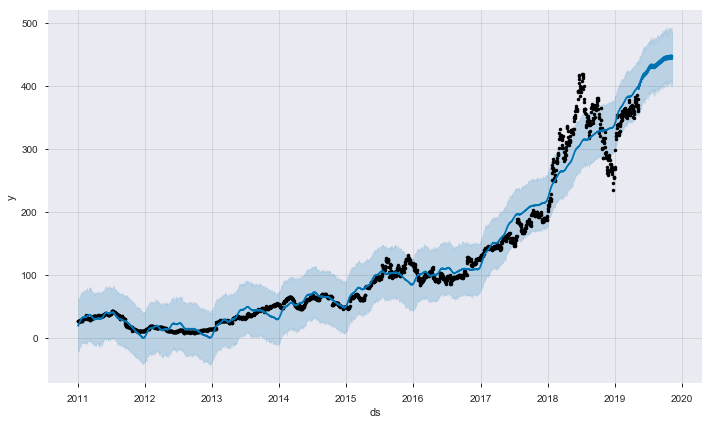

In [236]:
Model_nflx_half.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

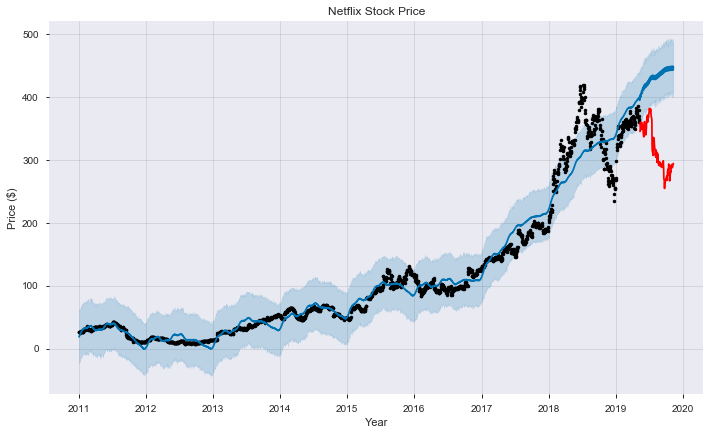

In [237]:
plt.figure(figsize=(20,15))
Model_nflx_half.plot(forecast, uncertainty=True)
plt.plot(nflx_end_half.ds, nflx_end_half.y, color='red')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

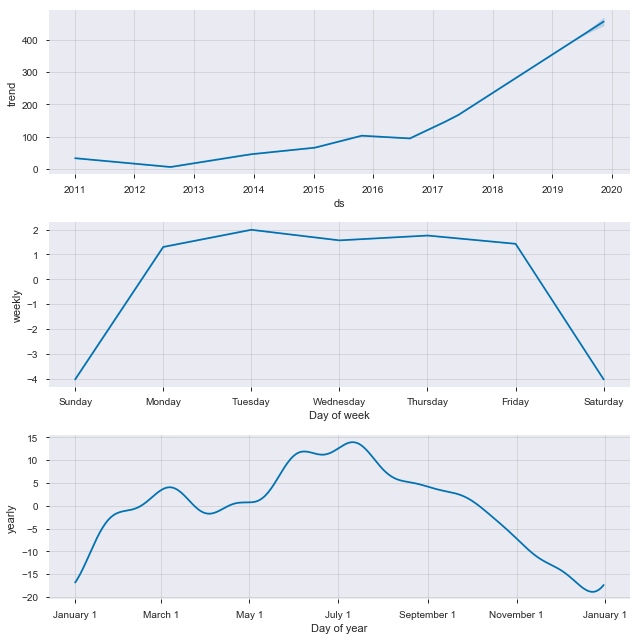

In [238]:
Model_nflx_half.plot_components(forecast);

## Fourth Forecast - 3 Month Prediction NFLX (01/01/2011-08/11/2019) Predict To 11/11/2019

In [239]:
nflx[:2165].tail()

ds           y
2160 2019-08-05  307.630005
2161 2019-08-06  310.100006
2162 2019-08-07  304.290009
2163 2019-08-08  315.899994
2164 2019-08-09  308.929993

In [240]:
nflx_start_quarter = nflx[:2165]
nflx_start_quarter.tail()

ds           y
2160 2019-08-05  307.630005
2161 2019-08-06  310.100006
2162 2019-08-07  304.290009
2163 2019-08-08  315.899994
2164 2019-08-09  308.929993

In [241]:
nflx_end_quarter = nflx[2165:]
nflx_end_quarter.tail()

ds           y
2225 2019-11-05  288.029999
2226 2019-11-06  288.589996
2227 2019-11-07  289.570007
2228 2019-11-08  291.570007
2229 2019-11-11  294.179993

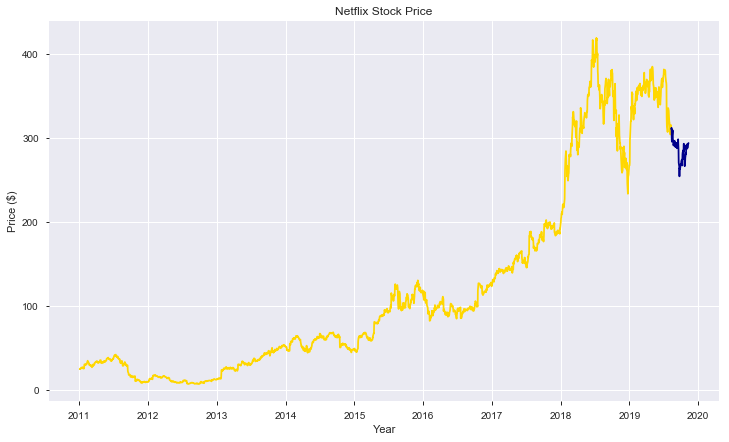

In [242]:
plt.figure(figsize=(12,7))
plt.plot(nflx_start_quarter.ds, nflx_start_quarter.y, color='gold')
plt.plot(nflx_end_quarter.ds, nflx_end_quarter.y, color='darkblue')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [243]:
Model_nflx_quarter = proph(interval_width=.95)

In [244]:
Model_nflx_quarter.fit(nflx_start_quarter)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [245]:
future_dates = Model_nflx_quarter.make_future_dataframe(periods=94, freq='D')

In [246]:
future_dates.tail()

ds
2254 2019-11-07
2255 2019-11-08
2256 2019-11-09
2257 2019-11-10
2258 2019-11-11

In [247]:
forecast = Model_nflx_quarter.predict(future_dates)

In [248]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2254 2019-11-07  398.075674  355.131497  440.574263
2255 2019-11-08  397.543634  353.463027  437.995498
2256 2019-11-09  392.217440  349.547940  434.720517
2257 2019-11-10  392.088871  345.784071  431.754968
2258 2019-11-11  397.086425  354.269715  439.876050

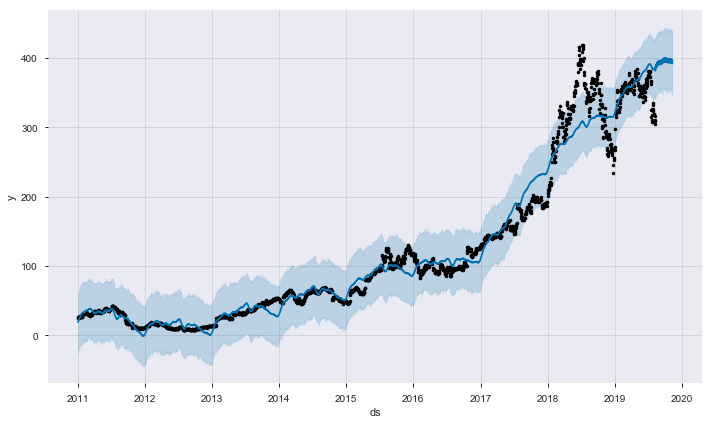

In [249]:
Model_nflx_quarter.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

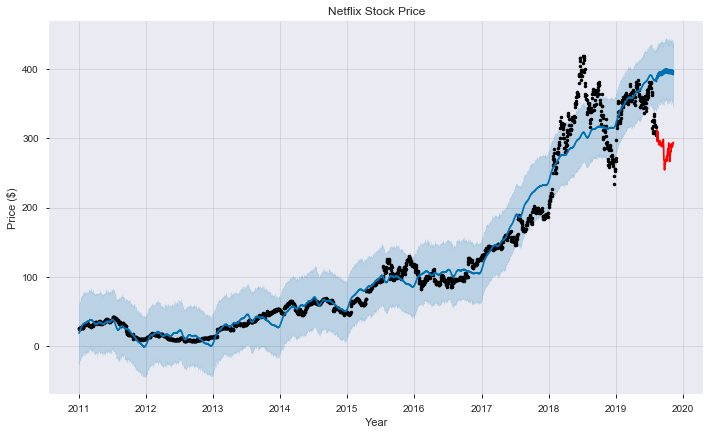

In [250]:
plt.figure(figsize=(20,15))
Model_nflx_quarter.plot(forecast, uncertainty=True)
plt.plot(nflx_end_quarter.ds, nflx_end_quarter.y, color='red')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

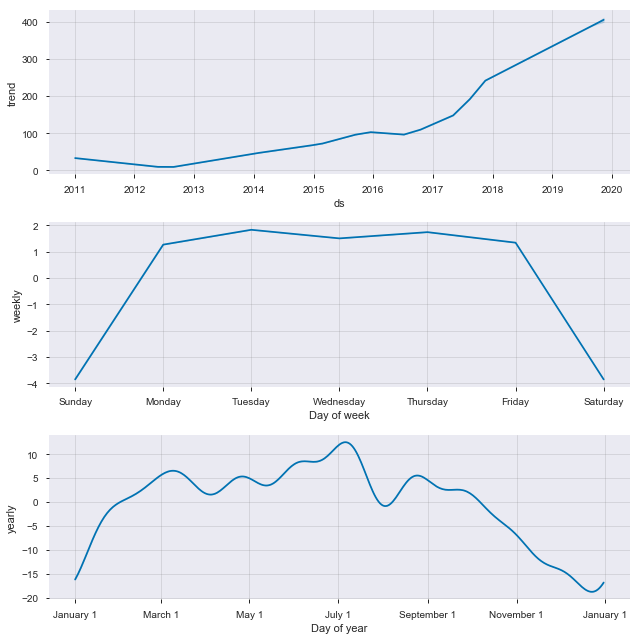

In [251]:
Model_nflx_quarter.plot_components(forecast);

## Fifth Forecast - 1 Month Prediction NFLX (01/01/2011-10/11/2019) Predict To 11/11/2019

In [252]:
nflx[:2209].tail()

ds           y
2204 2019-10-07  274.459991
2205 2019-10-08  270.720001
2206 2019-10-09  267.529999
2207 2019-10-10  280.480011
2208 2019-10-11  282.929993

In [253]:
nflx_start_month = nflx[:2209]
nflx_start_month.tail()

ds           y
2204 2019-10-07  274.459991
2205 2019-10-08  270.720001
2206 2019-10-09  267.529999
2207 2019-10-10  280.480011
2208 2019-10-11  282.929993

In [254]:
nflx_end_month = nflx[2209:]
nflx_end_month.tail()

ds           y
2225 2019-11-05  288.029999
2226 2019-11-06  288.589996
2227 2019-11-07  289.570007
2228 2019-11-08  291.570007
2229 2019-11-11  294.179993

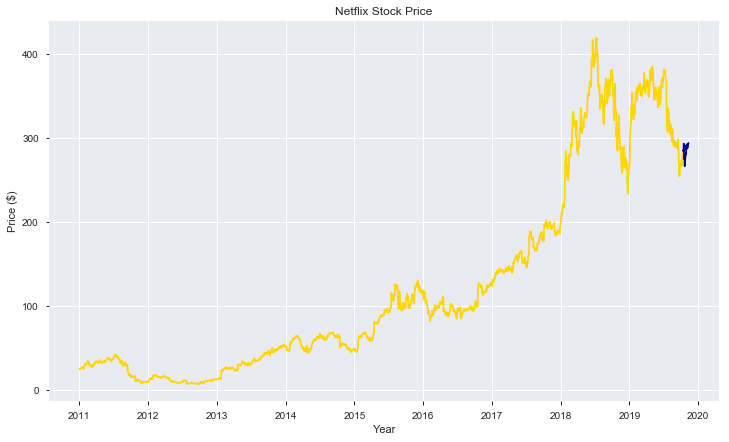

In [255]:
plt.figure(figsize=(12,7))
plt.plot(nflx_start_month.ds, nflx_start_month.y, color='gold')
plt.plot(nflx_end_month.ds, nflx_end_month.y, color='darkblue')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [256]:
Model_nflx_month = proph(interval_width=.95)

In [257]:
Model_nflx_month.fit(nflx_start_month)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [258]:
future_dates = Model_nflx_month.make_future_dataframe(periods=31, freq='D')

In [259]:
future_dates.tail()

ds
2235 2019-11-07
2236 2019-11-08
2237 2019-11-09
2238 2019-11-10
2239 2019-11-11

In [260]:
forecast = Model_nflx_month.predict(future_dates)

In [261]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2235 2019-11-07  348.644851  307.063952  391.220873
2236 2019-11-08  347.934871  307.511133  392.599701
2237 2019-11-09  342.237713  304.199190  386.402950
2238 2019-11-10  341.898899  298.451581  382.353300
2239 2019-11-11  347.025829  305.159160  389.390123

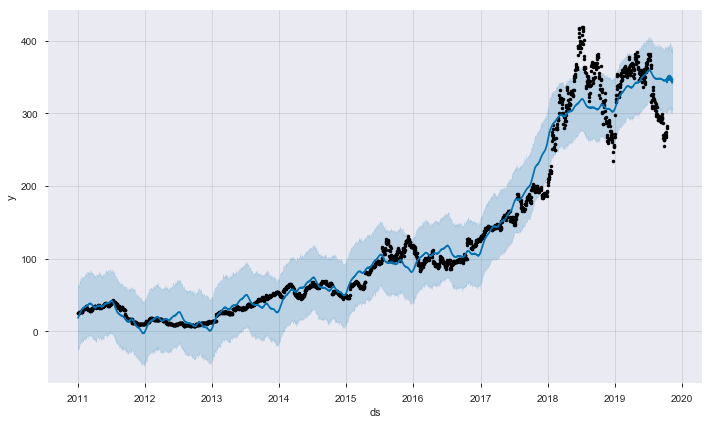

In [262]:
Model_nflx_month.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

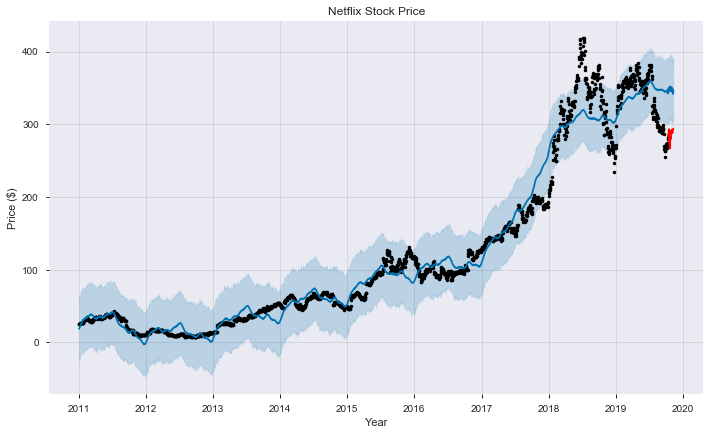

In [263]:
plt.figure(figsize=(20,15))
Model_nflx_month.plot(forecast, uncertainty=True)
plt.plot(nflx_end_month.ds, nflx_end_month.y, color='red')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

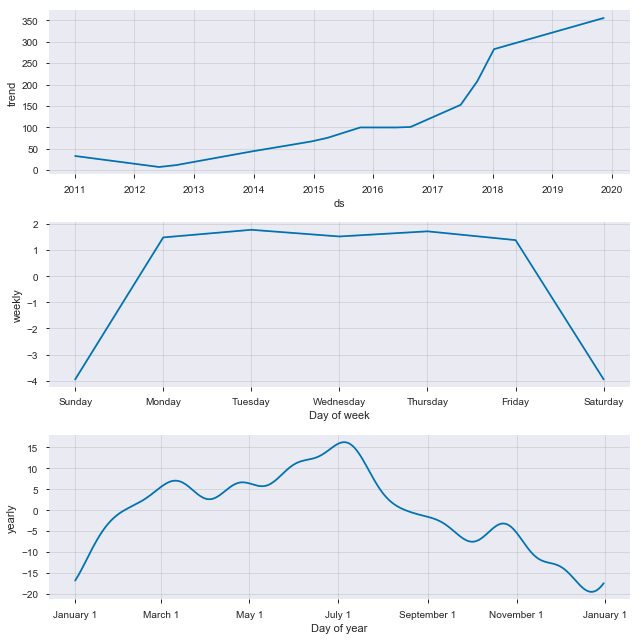

In [264]:
Model_nflx_month.plot_components(forecast);

## Sixth Forecast - 1 Week Prediction NFLX (01/01/2011-11/04/2019) Predict To 11/11/2019

In [265]:
nflx[:2225].tail()

ds           y
2220 2019-10-29  281.209991
2221 2019-10-30  291.450012
2222 2019-10-31  287.410004
2223 2019-11-01  286.809998
2224 2019-11-04  292.859985

In [266]:
nflx_start_week = nflx[:2225]
nflx_start_week.tail()

ds           y
2220 2019-10-29  281.209991
2221 2019-10-30  291.450012
2222 2019-10-31  287.410004
2223 2019-11-01  286.809998
2224 2019-11-04  292.859985

In [267]:
nflx_end_week = nflx[2225:]
nflx_end_week.head()

ds           y
2225 2019-11-05  288.029999
2226 2019-11-06  288.589996
2227 2019-11-07  289.570007
2228 2019-11-08  291.570007
2229 2019-11-11  294.179993

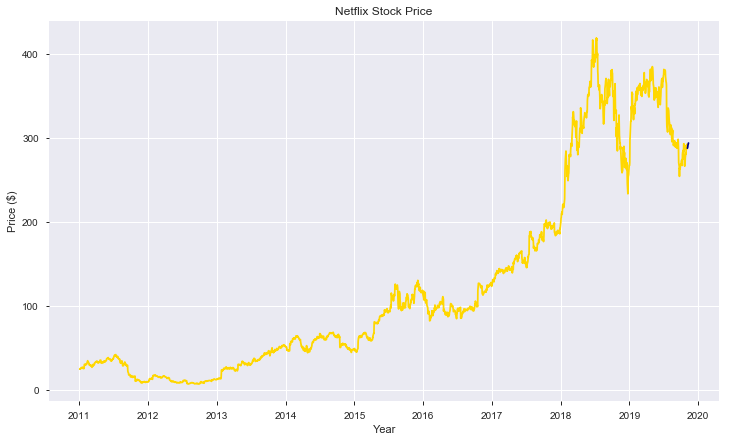

In [268]:
plt.figure(figsize=(12,7))
plt.plot(nflx_start_week.ds, nflx_start_week.y, color='gold')
plt.plot(nflx_end_week.ds, nflx_end_week.y, color='darkblue')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show();

In [269]:
Model_nflx_week = proph(interval_width=.95)

In [270]:
Model_nflx_week.fit(nflx_start_week)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Taylor/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [271]:
future_dates = Model_nflx_week.make_future_dataframe(periods=7, freq='D')

In [272]:
future_dates.tail()

ds
2227 2019-11-07
2228 2019-11-08
2229 2019-11-09
2230 2019-11-10
2231 2019-11-11

In [273]:
forecast = Model_nflx_week.predict(future_dates)

In [274]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2227 2019-11-07  332.635141  290.216625  371.911230
2228 2019-11-08  332.331825  290.212305  374.090636
2229 2019-11-09  326.435759  287.362683  371.541657
2230 2019-11-10  326.462264  286.169558  366.837096
2231 2019-11-11  332.366487  292.964415  372.276560

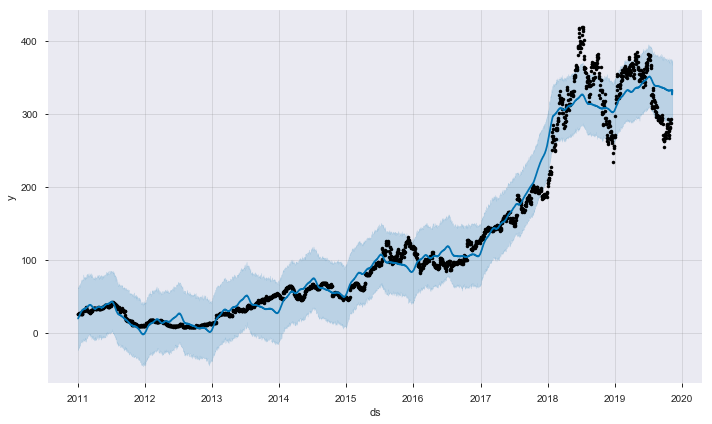

In [275]:
Model_nflx_week.plot(forecast, uncertainty=True);

<Figure size 1440x1080 with 0 Axes>

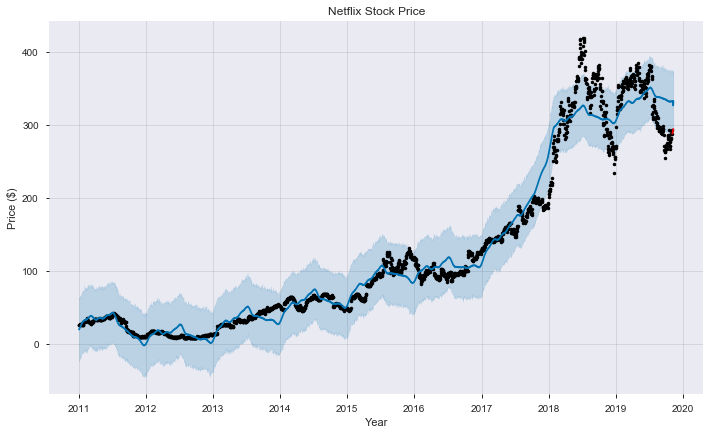

In [276]:
plt.figure(figsize=(20,15))
Model_nflx_week.plot(forecast, uncertainty=True)
plt.plot(nflx_end_week.ds, nflx_end_week.y, color='red')
plt.title('Netflix Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)');

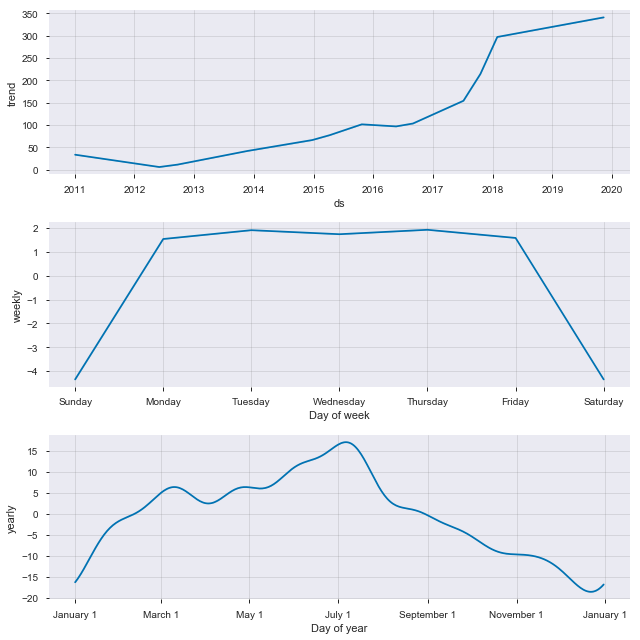

In [277]:
Model_nflx_week.plot_components(forecast);

#### Ultimately, it seems like our Apple example may have been a fluke. With 6 different predictions on 3 different stocks, very few predictions were even in the generous confidence interval. With parameter tuning and exogenous variables added, perhaps you can get more accurate predictions. But for the purposes of this project, it seems that predicting the stock market is a difficult undertaking.